# CKD Model Explanations: SHAP & LIME Analysis

This notebook generates automated SHAP and LIME explanations for all trained models.

**Key Features:**
- Iterates through multiple models automatically
- Compares **regular models** (trained on real data only) vs **augmented models** (trained with synthetic data)
- Handles different model types (Tree-based vs Linear) appropriately
- Analyzes explanation stability across model types
- Pipeline-aware transformations for SHAP and LIME

**Models Analyzed:**
- XGBoost
- Random Forest
- Logistic Regression

## 1. Setup and Imports

In [1]:
import sys
import random
import re
from pathlib import Path
import warnings

warnings.filterwarnings("ignore")

# --- Third-party ---
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility / reviewer-safe determinism
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# SHAP and LIME
import shap
from lime.lime_tabular import LimeTabularExplainer

from scipy.stats import spearmanr, kendalltau

# Scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
try:
    import xgboost
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    xgboost = None
    HAS_XGB = False
    print("⚠️ XGBoost not installed. XGBoost explanations will be skipped.")

# Add project root to path for imports
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Results output directory (all plots saved here)
RESULTS_DIR = PROJECT_ROOT / "results" / "plots"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

def _slugify_filename(text: str) -> str:
    """Filesystem-safe name for saved figures."""
    s = str(text).strip().lower()
    s = re.sub(r"[^a-z0-9]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s or "plot"

def save_current_matplotlib_figure(filename: str) -> Path:
    """Save the current matplotlib figure into RESULTS_DIR."""
    out_path = RESULTS_DIR / filename
    plt.savefig(out_path, bbox_inches="tight", dpi=200)
    return out_path

# Configuration (optional)
try:
    from src.config import CAT_COLS, CONT_COLS, ORD_COLS
except Exception:
    CAT_COLS, CONT_COLS, ORD_COLS = [], [], []
    print("⚠️ Could not import src.config. Continuing without it.")

# Clinical bounds (optional)
try:
    from src.cleaning import apply_clinical_bounds
except Exception:
    apply_clinical_bounds = None
    print("⚠️ Could not import apply_clinical_bounds. Will use local constraints only.")

# Display + style
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Version / environment report
print("✅ Imports loaded")
print(f"Python: {sys.version.split()[0]}")
print(f"SHAP: {shap.__version__}")
print(f"LIME: {getattr(__import__('lime'), '__version__', 'unknown')}")
print(f"XGBoost available: {HAS_XGB}")
if HAS_XGB and xgboost is not None:
    print(f"XGBoost: {xgboost.__version__}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Plots output dir: {RESULTS_DIR}")

# Guardrail: XGBoost >=3.1 + SHAP <0.50 is known to break TreeExplainer base_score parsing.
if HAS_XGB and xgboost is not None:
    try:
        from packaging.version import Version
        if Version(xgboost.__version__) >= Version("3.1.0") and Version(shap.__version__) < Version("0.50.0"):
            print("⚠️ Detected XGBoost>=3.1 with SHAP<0.50; TreeExplainer may fail.")
            print("   Switch kernel to: ckd-shap50 (Python 3.11) (shap==0.50.0)")
    except Exception:
        pass

✅ Imports loaded
Python: 3.11.14
SHAP: 0.50.0
LIME: unknown
XGBoost available: True
XGBoost: 3.1.3
Random seed: 42
Project root: e:\docs\FYP\demo\CKD_Risk_Prediction
Plots output dir: e:\docs\FYP\demo\CKD_Risk_Prediction\results\plots


## 2. Load Data

We load:
- **Raw split data** for LIME (needs raw features to perturb)
- **Labels** for both train and test sets

In [2]:

SPLIT_DIR = PROJECT_ROOT / 'data' / 'processed' / 'splits'
MODELS_DIR = PROJECT_ROOT / 'models'

# Prefer imputed raw splits (reviewer-safe: avoids introducing arbitrary zeros)
train_path = SPLIT_DIR / 'X_train_imputed_raw.csv'
test_path = SPLIT_DIR / 'X_test_imputed_raw.csv'
if not train_path.exists():
    train_path = SPLIT_DIR / 'X_train_raw.csv'
if not test_path.exists():
    test_path = SPLIT_DIR / 'X_test_raw.csv'

X_train_raw = pd.read_csv(train_path)
X_test_raw = pd.read_csv(test_path)

# Labels
y_train_df = pd.read_csv(SPLIT_DIR / 'y_train.csv')
y_test_df = pd.read_csv(SPLIT_DIR / 'y_test.csv')
y_train = y_train_df.iloc[:, 0].to_numpy().ravel()
y_test = y_test_df.iloc[:, 0].to_numpy().ravel()

# Basic type normalization (do NOT coerce categorical Yes/No into NaN)
if CONT_COLS or ORD_COLS:
    numeric_cols = [c for c in (CONT_COLS + ORD_COLS) if c in X_train_raw.columns]
else:
    # Fallback: treat obviously numeric columns as numeric
    numeric_cols = X_train_raw.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    X_train_raw[col] = pd.to_numeric(X_train_raw[col], errors='coerce')
    X_test_raw[col] = pd.to_numeric(X_test_raw[col], errors='coerce')

# If clinical bounds are available from the project, apply them consistently
if apply_clinical_bounds is not None:
    X_train_raw = apply_clinical_bounds(X_train_raw)
    X_test_raw = apply_clinical_bounds(X_test_raw)

print("✅ Data loaded successfully!")
print(f"   Train samples: {len(X_train_raw)}")
print(f"   Test samples: {len(X_test_raw)}")
print(f"   Features: {X_train_raw.shape[1]}")
print(f"   Using train file: {train_path.name}")
print(f"   Using test file : {test_path.name}")
print(f"\nTarget distribution (test):")
print(pd.Series(y_test).value_counts(normalize=True))


✅ Data loaded successfully!
   Train samples: 280
   Test samples: 120
   Features: 24
   Using train file: X_train_imputed_raw.csv
   Using test file : X_test_imputed_raw.csv

Target distribution (test):
1    0.625
0    0.375
Name: proportion, dtype: float64


## 3. Load Models

We load two sets of models:
- **Regular models**: Trained on real data only
- **Augmented models**: Trained with synthetic data augmentation (3x GCopula, seed=42)

In [4]:
# Load regular models (trained on real data only)
models_regular = {}

if HAS_XGB:
    models_regular['XGBoost'] = joblib.load(MODELS_DIR / 'xgb_baseline.joblib')
    print("✅ Loaded XGBoost (regular)")

models_regular['Random Forest'] = joblib.load(MODELS_DIR / 'rf_baseline.joblib')
print("✅ Loaded Random Forest (regular)")

models_regular['Logistic Regression'] = joblib.load(MODELS_DIR / 'lr_baseline.joblib')
print("✅ Loaded Logistic Regression (regular)")

# Load augmented models (trained with synthetic data)
models_augmented = {}

if HAS_XGB:
    models_augmented['XGBoost'] = joblib.load(MODELS_DIR / 'xgb_augmented_42_v1.joblib')
    print("✅ Loaded XGBoost (augmented)")

models_augmented['Random Forest'] = joblib.load(MODELS_DIR / 'rf_augmented_42_v1.joblib')
print("✅ Loaded Random Forest (augmented)")

models_augmented['Logistic Regression'] = joblib.load(MODELS_DIR / 'lr_augmented_42_v1.joblib')
print("✅ Loaded Logistic Regression (augmented)")

print(f"\n📊 Total models loaded: {len(models_regular)} regular + {len(models_augmented)} augmented")

# Debug: Inspect the first model's structure
print("\n🔍 DEBUG: Inspecting model structure...")
first_model = models_regular['Random Forest']
print(f"Model type: {type(first_model)}")
print(f"Pipeline steps: {first_model.steps if hasattr(first_model, 'steps') else 'Not a pipeline'}")
if hasattr(first_model, 'named_steps'):
    print(f"Named steps keys: {list(first_model.named_steps.keys())}")


✅ Loaded XGBoost (regular)
✅ Loaded Random Forest (regular)
✅ Loaded Logistic Regression (regular)
✅ Loaded XGBoost (augmented)
✅ Loaded Random Forest (augmented)
✅ Loaded Logistic Regression (augmented)

📊 Total models loaded: 3 regular + 3 augmented

🔍 DEBUG: Inspecting model structure...
Model type: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Pipeline steps: Not a pipeline


In [5]:
# Quick inspection of model / pipeline structure (safe for estimator-only artifacts)
print("\n" + "="*80)
print("🔍 PIPELINE STRUCTURE INSPECTION")
print("="*80)

sample_model = models_regular['Random Forest']
print(f"\nModel type: {type(sample_model).__name__}")

if hasattr(sample_model, 'steps'):
    print(f"\nPipeline steps ({len(sample_model.steps)}):")
    for i, (name, step) in enumerate(sample_model.steps):
        print(f"  Step {i}: '{name}' -> {type(step).__name__}")
else:
    print("\nNot a pipeline (this is expected after the canonical refactor).")

if hasattr(sample_model, 'named_steps'):
    print(f"\nNamed steps keys: {list(sample_model.named_steps.keys())}")



🔍 PIPELINE STRUCTURE INSPECTION

Model type: RandomForestClassifier

Not a pipeline (this is expected after the canonical refactor).


## 4. Utility Functions

These functions handle:
- Feature name extraction and cleaning
- Model type detection
- Data transformation

In [6]:
def extract_feature_names(model_or_pipeline):
    """Return feature names for a fitted pipeline's preprocessor, else fall back safely."""
    if hasattr(model_or_pipeline, 'named_steps') and 'preprocess' in model_or_pipeline.named_steps:
        pre = model_or_pipeline.named_steps['preprocess']
        if hasattr(pre, 'get_feature_names_out'):
            return list(pre.get_feature_names_out())
    return list(X_train_raw.columns)


def get_final_estimator(model_or_pipeline):
    """Get final estimator from Pipeline or estimator."""
    if hasattr(model_or_pipeline, 'named_steps') and 'model' in model_or_pipeline.named_steps:
        return model_or_pipeline.named_steps['model']
    if hasattr(model_or_pipeline, 'steps'):
        return model_or_pipeline.steps[-1][1]
    return model_or_pipeline


def is_tree_based_model(estimator):
    """Strict model-family detection for SHAP explainer choice."""
    tree_types = (RandomForestClassifier,)
    if HAS_XGB:
        tree_types = tree_types + (XGBClassifier,)
    return isinstance(estimator, tree_types)


def is_linear_model(estimator):
    return isinstance(estimator, LogisticRegression)


def get_transformed_X(pipeline, X_raw: pd.DataFrame, feature_names: list[str] | None = None) -> pd.DataFrame:
    """Transform raw X through pipeline.preprocess and return a DataFrame with names."""
    if not (hasattr(pipeline, 'named_steps') and 'preprocess' in pipeline.named_steps):
        raise TypeError("Expected a Pipeline with a 'preprocess' step")
    pre = pipeline.named_steps['preprocess']
    Xt = pre.transform(X_raw)
    if hasattr(Xt, 'toarray'):
        Xt = Xt.toarray()
    if feature_names is None:
        feature_names = extract_feature_names(pipeline)
    return pd.DataFrame(Xt, columns=feature_names, index=X_raw.index)


def predict_proba_pipeline(pipeline, X_raw: pd.DataFrame) -> np.ndarray:
    """Deterministic predict_proba through a Pipeline."""
    if not hasattr(pipeline, 'predict_proba'):
        raise TypeError('Model must implement predict_proba')
    return pipeline.predict_proba(X_raw)


print('✅ Utility functions defined (pipeline-first, reviewer-safe).')

✅ Utility functions defined (pipeline-first, reviewer-safe).


## 5. SHAP Explanation Functions

SHAP (SHapley Additive exPlanations) provides additive feature attributions.

**Reviewer-safe explainer choice (model-specific):**
- **Logistic Regression** → `shap.LinearExplainer`
- **Random Forest** → `shap.TreeExplainer`
- **XGBoost** → `shap.TreeExplainer`

**Critical detail:** SHAP is computed in the **exact transformed feature space** the model was trained on (i.e., after the pipeline preprocessor).

## 5.1 SHAP (Pipeline-Consistent) + Data Cleaning + Clinical Constraints

This section enforces technical correctness for healthcare review:
1. **No KernelExplainer** for linear/tree models (avoids unnecessary approximation)
2. Uses the **training-time transformed space** for SHAP values
3. Enforces **clinical constraints** before explanation to avoid implausible perturbations

In [7]:
import json
import re
import contextlib
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1. THE SAFETY NET (Monkey Patch)
# ==========================================
@contextlib.contextmanager
def fix_xgboost_base_score():
    """
    Temporarily patches XGBoost's Booster.save_config() and json.loads() so SHAP
    can safely parse model metadata when base_score is serialized like "[6.25E-1]".

    Why both patches?
    - Some SHAP/XGBoost stacks parse `save_config()` with different JSON loaders.
      Sanitizing the JSON string itself is the most robust fix.
    - We also sanitize parsed dicts as a secondary safety net.
    """
    # 1) Patch json.loads to sanitize parsed objects (secondary safety net)
    original_json_loads = json.loads

    def _sanitize_base_score_value(v):
        if not isinstance(v, str):
            return v
        s = v.strip()
        # Convert bracketed scalar strings like "[6.25E-1]" -> "6.25E-1"
        if s.startswith('[') and s.endswith(']'):
            s = s[1:-1].strip()
        # Also strip any stray quotes
        s = s.strip('"\' ')
        return s

    def _walk_and_sanitize(obj):
        if isinstance(obj, dict):
            for k, v in list(obj.items()):
                if k == 'base_score':
                    obj[k] = _sanitize_base_score_value(v)
                else:
                    _walk_and_sanitize(v)
        elif isinstance(obj, list):
            for it in obj:
                _walk_and_sanitize(it)

    def patched_loads(s, **kwargs):
        data = original_json_loads(s, **kwargs)
        try:
            _walk_and_sanitize(data)
        except Exception:
            pass
        return data

    # 2) Patch Booster.save_config() to sanitize the JSON string directly (primary fix)
    xgb_module = None
    original_save_config = None
    try:
        import xgboost as xgb_module  # type: ignore
        original_save_config = xgb_module.core.Booster.save_config
    except Exception:
        xgb_module = None
        original_save_config = None

    def _sanitize_save_config_json(cfg: str) -> str:
        # Replace: "base_score":"[6.25E-1]"  ->  "base_score":"6.25E-1"
        # (Keep it as a string; SHAP will float() it.)
        return re.sub(r'("base_score"\s*:\s*)"\[([^\]]+)\]"', r'\1"\2"', cfg)

    def patched_save_config(self):
        cfg = original_save_config(self)
        if isinstance(cfg, str):
            cfg = _sanitize_save_config_json(cfg)
        return cfg

    # Apply patches
    json.loads = patched_loads
    if xgb_module is not None and original_save_config is not None:
        xgb_module.core.Booster.save_config = patched_save_config
    try:
        yield
    finally:
        # Restore originals immediately
        json.loads = original_json_loads
        if xgb_module is not None and original_save_config is not None:
            xgb_module.core.Booster.save_config = original_save_config


def _as_2d_shap_values_for_class1(shap_vals) -> np.ndarray:
    """Normalize SHAP outputs into shape (n_samples, n_features) for class 1.

    SHAP APIs can return:
    - list([class0, class1])
    - ndarray (n_samples, n_features)
    - ndarray (n_samples, n_features, n_classes)
    - ndarray (n_features,) for single instance
    """
    if isinstance(shap_vals, list):
        # For binary classification, class 1 is the positive class of interest
        if len(shap_vals) >= 2:
            shap_vals = shap_vals[1]
        else:
            shap_vals = shap_vals[0]
    arr = np.asarray(shap_vals)
    if arr.ndim == 3:
        # Most common: (n_samples, n_features, 2) -> keep class 1
        if arr.shape[-1] == 2:
            arr = arr[:, :, 1]
        else:
            # Fallback: reduce last axis if it isn't a class axis (keeps notebook running)
            arr = arr.mean(axis=-1)
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    return np.asarray(arr)


def compute_shap_values(pipeline, X_background_raw, X_explain_raw, *, kernel_kmeans_k: int = 10):
    """
    Robust SHAP computation that handles Pipeline transforms and XGBoost errors.

    Improvements (robustness + efficiency):
    - Uses model-specific explainers for linear/tree models
    - KernelExplainer fallback uses a K-Means summarized background via `shap.kmeans(..., k=kernel_kmeans_k)`
      instead of passing the full training/background set.

    Returns:
    - shap_values_2d: np.ndarray shape (n_samples, n_features) for class 1
    - X_used: pd.DataFrame aligned to shap_values_2d columns
    - feature_names: list[str]
    """
    estimator = get_final_estimator(pipeline)
    feature_names = extract_feature_names(pipeline)

    # 1) Transform to the exact feature space the estimator sees
    try:
        if hasattr(pipeline, 'named_steps') and 'preprocess' in pipeline.named_steps:
            preprocessor = pipeline.named_steps['preprocess']
            Xb_t = preprocessor.transform(X_background_raw)
            Xe_t = preprocessor.transform(X_explain_raw)
        else:
            Xb_t = X_background_raw
            Xe_t = X_explain_raw

        Xb_t = pd.DataFrame(Xb_t, columns=feature_names)
        Xe_t = pd.DataFrame(Xe_t, columns=feature_names)
    except Exception as e:
        print(f"⚠️ Preprocessing failed in SHAP: {e}")
        return None, None, None

    # 2) Model-specific explainers
    try:
        if is_linear_model(estimator):
            explainer = shap.LinearExplainer(estimator, Xb_t, feature_perturbation='interventional')
            shap_vals = explainer.shap_values(Xe_t)
            shap_vals = _as_2d_shap_values_for_class1(shap_vals)
            return shap_vals, Xe_t, feature_names

        if is_tree_based_model(estimator):
            # XGBoost base_score fix applied only during explainer creation and SHAP call
            with fix_xgboost_base_score():
                explainer = shap.TreeExplainer(estimator, data=Xb_t, feature_perturbation='interventional')
                shap_vals = explainer.shap_values(Xe_t)
            shap_vals = _as_2d_shap_values_for_class1(shap_vals)
            return shap_vals, Xe_t, feature_names
    except Exception as e:
        print(f"❌ SHAP Explainer Failed: {e}")

    # 3) Fallback: KernelExplainer on class-1 probability (keeps output 2D)
    try:
        print("🔄 Attempting fallback to KernelExplainer (K-Means background)...")
        bg = X_background_raw
        if not isinstance(bg, pd.DataFrame):
            bg = pd.DataFrame(bg, columns=getattr(X_explain_raw, 'columns', None))

        bg_np = bg.to_numpy()
        k = int(kernel_kmeans_k)
        if k <= 0:
            k = 10
        k = min(k, max(1, bg_np.shape[0]))
        bg_summary = shap.kmeans(bg_np, k=k)

        def predict_class1(x_np: np.ndarray) -> np.ndarray:
            Xdf = pd.DataFrame(x_np, columns=bg.columns)
            return pipeline.predict_proba(Xdf)[:, 1]

        explainer = shap.KernelExplainer(predict_class1, bg_summary)
        shap_vals = explainer.shap_values(X_explain_raw.to_numpy())
        shap_vals = _as_2d_shap_values_for_class1(shap_vals)
        return shap_vals, X_explain_raw, list(X_explain_raw.columns)
    except Exception as k_e:
        print(f"❌ KernelExplainer also failed: {k_e}")
        return None, None, None


def plot_shap_summary(shap_values: np.ndarray, X_transformed: pd.DataFrame, title: str, *, save_filename: str | None = None):
    """Small helper to keep plots consistent and reviewer-friendly; optionally saves to RESULTS_DIR."""
    plt.figure(figsize=(12, 7))
    shap.summary_plot(shap_values, X_transformed, show=False)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    if save_filename:
        save_current_matplotlib_figure(save_filename)
    plt.show()


def plot_shap_dependence_top_features(
    shap_values: np.ndarray,
    X_transformed: pd.DataFrame,
    model_tag: str,
    *,
    top_n: int = 3,
    save_prefix: str = "shap_dependence",
    ):
    """Generate + save dependence plots for the top-N features by mean(|SHAP|)."""
    imp = pd.Series(np.abs(shap_values).mean(axis=0), index=list(X_transformed.columns)).sort_values(ascending=False)
    top_features = imp.head(int(top_n)).index.tolist()
    for feat in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(feat, shap_values, X_transformed, show=False)
        plt.title(f"SHAP Dependence: {model_tag} | {feat}")
        plt.tight_layout()
        fname = f"{save_prefix}__{_slugify_filename(model_tag)}__{_slugify_filename(feat)}.png"
        save_current_matplotlib_figure(fname)
        plt.show()


print("✅ Patched SHAP functions loaded successfully.")

✅ Patched SHAP functions loaded successfully.


## 6. Clinical Validation + Canonical Model Pipeline Wrapper

All models (real and augmented) must operate in the **same canonical feature space**:

- `['hemo','sc','al','htn','age','dm']`

To keep prediction/SHAP/LIME consistent, we wrap estimators inside a Pipeline that reproduces the canonical preprocessing exactly, and we enforce clinical constraints before prediction.

In [8]:
# ------------------ Clinical constraints (explicit, reviewer-facing) ------------------
# Ranges are intentionally conservative; adjust if your clinical protocol differs.
CLINICAL_CONSTRAINTS = {
    'age': (0.0, 120.0),
    'bp': (30.0, 250.0),
    'hemo': (0.0, 25.0),
    'sc': (0.0, 25.0),
    'bgr': (0.0, 700.0),
    'bu': (0.0, 300.0),
    'sod': (90.0, 200.0),
    'pot': (1.0, 10.0),
    'sg': (1.000, 1.050),
    'al': (0.0, 5.0),
    'su': (0.0, 5.0),
    'pcv': (0.0, 70.0),
    'wc': (0.0, 40000.0),
    'rc': (0.0, 10.0),
}


def enforce_clinical_constraints(X: pd.DataFrame, *, strict: bool = False) -> pd.DataFrame:
    """
    Enforce medically plausible ranges.

    - If strict=False: clips numeric values into range (projection).
    - If strict=True: raises ValueError if any value violates constraints.

    This is applied inside prediction wrappers so LIME perturbations remain plausible.
    """
    Xc = X.copy()
    for col, (lo, hi) in CLINICAL_CONSTRAINTS.items():
        if col not in Xc.columns:
            continue
        col_vals = pd.to_numeric(Xc[col], errors='coerce')
        if strict and ((col_vals < lo) | (col_vals > hi)).any():
            bad = Xc.index[((col_vals < lo) | (col_vals > hi)).fillna(False)].tolist()[:5]
            raise ValueError(f'Clinical constraint violated for {col} in rows {bad} (range {lo}..{hi}).')
        Xc[col] = col_vals.clip(lo, hi)

    # Binary-ish columns: project to {0,1} when numeric
    for bcol in ['htn', 'dm', 'cad', 'pe', 'ane', 'rbc', 'pc', 'pcc', 'ba']:
        if bcol in Xc.columns and pd.api.types.is_numeric_dtype(Xc[bcol]):
            Xc[bcol] = (pd.to_numeric(Xc[bcol], errors='coerce') >= 0.5).astype(float)
    return Xc


def clean_shap_data(data):
    """Convert bracket-wrapped numeric strings (e.g., '[0.625]') to floats."""
    if isinstance(data, np.ndarray):
        df = pd.DataFrame(data)
    else:
        df = data.copy()
    for col in df.columns:
        if df[col].dtype == 'object':
            original = df[col]
            s = df[col].astype(str).str.strip()
            if s.str.contains(r'\[.*\]').any():
                s = s.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
            converted = pd.to_numeric(s, errors='coerce')
            # Keep non-numeric entries as-is (only replace where conversion succeeded)
            df[col] = converted.where(converted.notna(), original)
    return df


from src.canonical import (
    CANONICAL_FEATURES,
    CanonicalPreprocessor,
    assert_canonical_schema,
    forbid_onehot_residuals,
 )


class Canonical6Preprocessor(BaseEstimator, TransformerMixin):
    """
    Deterministic transformer that reproduces the project's canonical preprocessing.

    - Selects only CANONICAL_FEATURES
    - Coerces dm/htn to {0,1}
    - Imputes missing values learned on fit() data
    - Preserves numeric scale (no StandardScaler / no one-hot)
    """
    def __init__(self, seed: int = RANDOM_SEED):
        self.seed = int(seed)
        self.preproc_: CanonicalPreprocessor | None = None
        self.feature_names_out_ = list(CANONICAL_FEATURES)

    def fit(self, X, y=None):
        Xdf = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        Xdf = enforce_clinical_constraints(Xdf, strict=False)
        if apply_clinical_bounds is not None:
            try:
                Xdf = apply_clinical_bounds(Xdf)
            except Exception:
                pass
        pre = CanonicalPreprocessor().fit(Xdf)
        self.preproc_ = pre
        return self

    def transform(self, X):
        if self.preproc_ is None:
            raise RuntimeError('Canonical6Preprocessor is not fitted.')
        Xdf = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        Xdf = enforce_clinical_constraints(Xdf, strict=False)
        if apply_clinical_bounds is not None:
            try:
                Xdf = apply_clinical_bounds(Xdf)
            except Exception:
                pass
        Xt = self.preproc_.transform(Xdf)
        forbid_onehot_residuals(list(Xt.columns))
        assert_canonical_schema(Xt)
        return Xt.values

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_out_, dtype=object)


def wrap_estimator_as_pipeline(estimator, X_train_raw: pd.DataFrame) -> Pipeline:
    """Wrap an estimator into a Pipeline so prediction/SHAP/LIME share canonical preprocessing."""
    pre = Canonical6Preprocessor()
    pre.fit(X_train_raw)
    return Pipeline([('preprocess', pre), ('model', estimator)])


def wrap_augmented_as_pipeline(estimator, X_train_raw: pd.DataFrame) -> Pipeline:
    """Backward-compatible alias (older cells call this)."""
    return wrap_estimator_as_pipeline(estimator, X_train_raw)


# Canonical raw views for explanation (keeps LIME/SHAP focused on the 6 non-negotiable features)
_missing = [c for c in CANONICAL_FEATURES if c not in X_train_raw.columns]
if _missing:
    raise KeyError(f"Missing canonical columns in raw split data: {_missing}")

X_train_canonical = X_train_raw.loc[:, CANONICAL_FEATURES].copy()
X_test_canonical = X_test_raw.loc[:, CANONICAL_FEATURES].copy()

print('✅ Clinical constraints + canonical preprocessing defined.')
print(f"✅ Canonical explanation data prepared: {list(CANONICAL_FEATURES)}")


✅ Clinical constraints + canonical preprocessing defined.
✅ Canonical explanation data prepared: ['hemo', 'sc', 'al', 'htn', 'age', 'dm']


## 6.1 LIME Explanation Functions

LIME (Local Interpretable Model-agnostic Explanations) perturbs **raw clinical features** and fits a local surrogate model.

**Non‑negotiable stability fix implemented here:**
- Run LIME **N ≥ 10** times with deterministic seeds
- Aggregate feature importance across runs (mean + mean absolute weight)
- Keep both outputs: **single explanation** and **aggregated explanation**

**Pipeline consistency:** every perturbed sample is fed through the **same preprocessing + model pipeline** used for training/prediction.

In [8]:
def _lime_predict_fn_from_pipeline(pipeline: Pipeline, raw_columns: list[str]):
    """
    Build a predict_fn for LIME that applies the exact preprocessing pipeline.
    Also projects perturbed samples into clinically plausible ranges.
    """
    def predict_fn(x):
        X = x
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=raw_columns)
        X = enforce_clinical_constraints(X, strict=False)
        if apply_clinical_bounds is not None:
            try:
                X = apply_clinical_bounds(X)
            except Exception:
                pass
        return pipeline.predict_proba(X)
    return predict_fn


def generate_lime_single_and_aggregated(
    pipeline: Pipeline,
    X_train_raw: pd.DataFrame,
    X_test_raw: pd.DataFrame,
    model_name: str,
    sample_idx: int = 0,
    n_runs: int = 10,
    base_seed: int = RANDOM_SEED,
    num_features: int = 10,
    num_samples: int = 1000,
    class_names=('No CKD', 'CKD'),
    ):
    """
    Generate LIME explanations N>=10 times and aggregate feature importance.

    Output:
    - single_exp: first-run explanation (for human-readable local narrative)
    - agg_df: aggregated weights across runs (mean + mean|w|)
    """
    if n_runs < 10:
        raise ValueError('LIME stability requirement: n_runs must be >= 10')

    raw_cols = X_train_raw.columns.tolist()
    predict_fn = _lime_predict_fn_from_pipeline(pipeline, raw_cols)

    # Use the same training distribution LIME expects (raw space); preprocessing happens inside predict_fn.
    # We vary only the LIME sampler seed deterministically across runs.
    sample_series = X_test_raw.iloc[sample_idx]
    sample = sample_series.to_numpy()

    # Identify categorical features for LIME (robust)
    from pandas.api.types import is_object_dtype
    from pandas.api.types import CategoricalDtype

    def _is_cat(series: pd.Series) -> bool:
        try:
            return isinstance(series.dtype, CategoricalDtype) or is_object_dtype(series.dtype)
        except Exception:
            return False

    categorical_features = [i for i, col in enumerate(raw_cols) if _is_cat(X_train_raw[col])]
    categorical_names = {i: list(pd.Series(X_train_raw.iloc[:, i]).dropna().unique()) for i in categorical_features}

    weights_per_run = []
    single_exp = None

    for i in range(n_runs):
        explainer = LimeTabularExplainer(
            training_data=X_train_raw.to_numpy(),
            feature_names=raw_cols,
            class_names=list(class_names),
            mode='classification',
            random_state=base_seed + i,
            discretize_continuous=False,
            categorical_features=categorical_features,
            categorical_names=categorical_names
        )
        exp = explainer.explain_instance(
            data_row=sample,
            predict_fn=predict_fn,
            num_features=num_features,
            num_samples=num_samples,
            labels=(1,),
        )
        if single_exp is None:
            single_exp = exp
        local = dict(exp.local_exp[1])  # {feature_index: weight}
        weights_per_run.append(local)

    # Aggregate on indices for integrity; map to clinical feature names afterwards.
    n_feat = len(raw_cols)
    W = np.zeros((n_runs, n_feat), dtype=float)
    for r, local in enumerate(weights_per_run):
        for j, w in local.items():
            if 0 <= j < n_feat:
                W[r, j] = float(w)

    agg = pd.DataFrame({
        'feature': raw_cols,
        'lime_weight_mean': W.mean(axis=0),
        'lime_weight_mean_abs': np.abs(W).mean(axis=0),
        'lime_weight_std_abs': np.abs(W).std(axis=0, ddof=0),
    })
    agg = agg.sort_values('lime_weight_mean_abs', ascending=False).reset_index(drop=True)

    print(f"\n✅ LIME complete for {model_name} (sample #{sample_idx})")
    print(f"   Runs: {n_runs} | Base seed: {base_seed} | Num samples/run: {num_samples}")

    return single_exp, agg


print('✅ LIME functions defined (single + aggregated, deterministic).')


✅ LIME functions defined (single + aggregated, deterministic).


## 7. Explanation Stability Analysis

We'll measure **explanation stability** by computing:
- **Feature importance variance**: How consistent are feature rankings?
- **Top-K feature agreement**: How often do the top features overlap?
- **Mean absolute difference**: Average difference in SHAP values

In [9]:
def collapse_importance(importance: pd.Series) -> pd.Series:
    """Canonical pipelines already expose base clinical features.

    This is intentionally a no-op kept for backward compatibility with older notebooks.
    """
    return importance.sort_values(ascending=False)


def _kendall_tau_topk(imp_reg: pd.Series, imp_aug: pd.Series, *, topk: int = 10) -> float:
    """Kendall's Tau rank correlation on the Top-K feature order (robust to scale).

    We compute ranks on the union of Top-K features from both models.
    Features missing from a model's Top-K get a worst-rank penalty (topk+1).
    """
    topk = int(topk)
    if topk <= 1:
        return float('nan')

    top_reg = imp_reg.head(topk).index.tolist()
    top_aug = imp_aug.head(topk).index.tolist()
    union = list(dict.fromkeys(top_reg + top_aug))
    if len(union) < 2:
        return float('nan')

    rank_reg = {f: i + 1 for i, f in enumerate(top_reg)}
    rank_aug = {f: i + 1 for i, f in enumerate(top_aug)}
    worst = topk + 1
    r1 = [rank_reg.get(f, worst) for f in union]
    r2 = [rank_aug.get(f, worst) for f in union]
    tau, _ = kendalltau(r1, r2)
    return float(tau) if np.isfinite(tau) else float('nan')


def compute_stability_metrics(
    shap_values_regular,
    feature_names_regular,
    shap_values_augmented,
    feature_names_augmented,
    k: int = 5,
    ):
    """Compare SHAP importances between regular vs augmented in the same canonical feature space."""
    imp_reg = pd.Series(np.abs(shap_values_regular).mean(axis=0), index=feature_names_regular)
    imp_aug = pd.Series(np.abs(shap_values_augmented).mean(axis=0), index=feature_names_augmented)

    imp_reg = collapse_importance(imp_reg)
    imp_aug = collapse_importance(imp_aug)

    common = sorted(set(imp_reg.index) & set(imp_aug.index))
    if not common:
        return {
            'top_k_overlap': np.nan,
            'importance_correlation': np.nan,
            'kendall_tau_top10': np.nan,
            'mean_abs_difference': np.nan,
            'std_abs_difference': np.nan,
            'n_common_features': 0,
        }

    v_reg = imp_reg.loc[common].to_numpy()
    v_aug = imp_aug.loc[common].to_numpy()

    top_reg = set(np.argsort(v_reg)[-k:])
    top_aug = set(np.argsort(v_aug)[-k:])
    overlap = len(top_reg & top_aug) / float(k)

    return {
        'top_k_overlap': float(overlap),
        'importance_correlation': float(np.corrcoef(v_reg, v_aug)[0, 1]),
        'kendall_tau_top10': _kendall_tau_topk(imp_reg, imp_aug, topk=10),
        'mean_abs_difference': float(np.mean(np.abs(v_reg - v_aug))),
        'std_abs_difference': float(np.std(np.abs(v_reg - v_aug), ddof=0)),
        'n_common_features': int(len(common)),
    }


print('✅ Stability comparison updated (canonical-feature aligned + Kendall Tau top-10).')

✅ Stability comparison updated (canonical-feature aligned + Kendall Tau top-10).


## 7.5 Explanation Stability Score (ESS) — Perturbation-Based

We evaluate *within-model* explanation stability by:
- Adding small Gaussian noise to a patient instance (continuous clinical variables only)
- Recomputing SHAP explanations in the **transformed** model feature space
- Computing Spearman rank correlation between original vs perturbed feature-importance rankings

**Metric:** `Explanation Stability Score (ESS)` = mean Spearman correlation across perturbations (higher = more stable).

In [10]:
def explanation_stability_score_ess(
    pipeline: Pipeline,
    X_background_raw: pd.DataFrame,
    instance_raw: pd.Series | pd.DataFrame,
    n_perturb: int = 30,
    noise_frac: float = 0.01,
    seed: int = RANDOM_SEED,
    ) -> float:
    """
    Explanation Stability Score (ESS) via SHAP + Spearman rank correlation.

    - Perturbs continuous columns with small Gaussian noise
    - Enforces clinical constraints before prediction/explanation
    - Computes mean Spearman correlation of feature-importance ranks
    """
    rng = np.random.default_rng(seed)
    if isinstance(instance_raw, pd.Series):
        x0 = instance_raw.to_frame().T
    else:
        x0 = instance_raw.copy()
    x0 = enforce_clinical_constraints(x0, strict=True)
    if apply_clinical_bounds is not None:
        x0 = apply_clinical_bounds(x0)

    # Determine continuous columns to perturb (prefer config when available)
    if CONT_COLS:
        cont = [c for c in CONT_COLS if c in x0.columns]
    else:
        cont = [c for c in x0.columns if c not in ['htn','dm','cad','pe','ane']]
    # scale noise based on background std
    bg = X_background_raw[cont].apply(pd.to_numeric, errors='coerce')
    sigma = bg.std(axis=0, ddof=0).replace(0, 1.0)
    sigma = (sigma * float(noise_frac)).to_dict()

    # baseline explanation
    shap0, X0_t, fnames = compute_shap_values(pipeline, X_background_raw, x0)
    imp0 = pd.Series(np.abs(shap0).mean(axis=0), index=fnames)
    imp0 = collapse_importance(imp0)
    base = imp0.index.tolist()
    v0 = imp0.to_numpy()
    if len(base) < 2:
        return float('nan')

    cors = []
    for _ in range(int(n_perturb)):
        x = x0.copy()
        for c in cont:
            if c in x.columns:
                x[c] = pd.to_numeric(x[c], errors='coerce') + rng.normal(0.0, sigma.get(c, 0.0), size=len(x))
        x = enforce_clinical_constraints(x, strict=False)
        if apply_clinical_bounds is not None:
            x = apply_clinical_bounds(x)
        sh, _, fn = compute_shap_values(pipeline, X_background_raw, x)
        imp = pd.Series(np.abs(sh).mean(axis=0), index=fn)
        imp = collapse_importance(imp)
        # align to baseline features
        imp = imp.reindex(base).fillna(0.0)
        rho, _ = spearmanr(v0, imp.to_numpy())
        if np.isfinite(rho):
            cors.append(float(rho))

    return float(np.mean(cors)) if cors else float('nan')


print('✅ ESS (Explanation Stability Score) function defined.')

✅ ESS (Explanation Stability Score) function defined.


## 8. Main Explanation Loop

This is the core automation:
- Iterates through all models
- Generates SHAP and LIME explanations
- Compares regular vs augmented models
- Computes stability metrics

🚀 STARTING EXPLANATION GENERATION FOR ALL MODELS

📍 Explaining sample #0 from test set
   True label: CKD = 1


🔍 MODEL FAMILY: XGBoost

--------------------------------------------------------------------------------
📊 REGULAR MODEL (trained on real data only)
   Estimator: XGBClassifier | Features (transformed): 6
--------------------------------------------------------------------------------


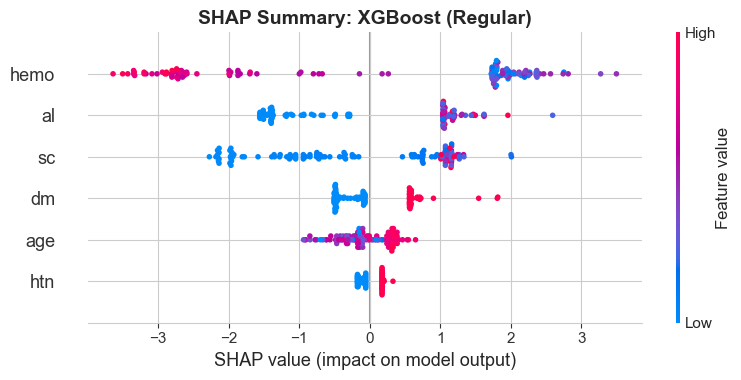

<Figure size 1000x600 with 0 Axes>

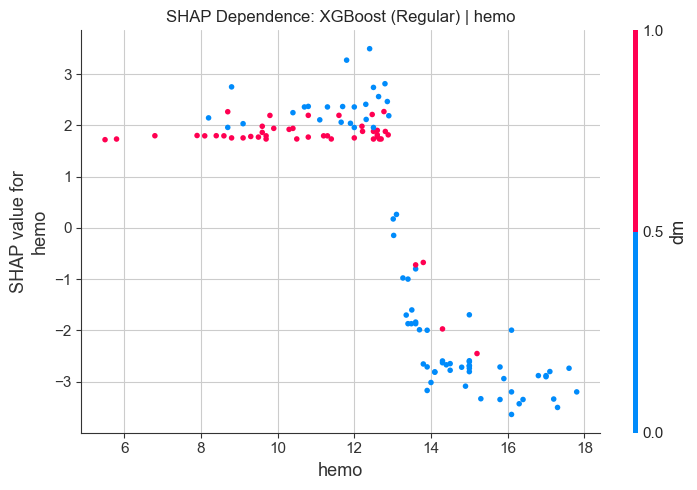

<Figure size 1000x600 with 0 Axes>

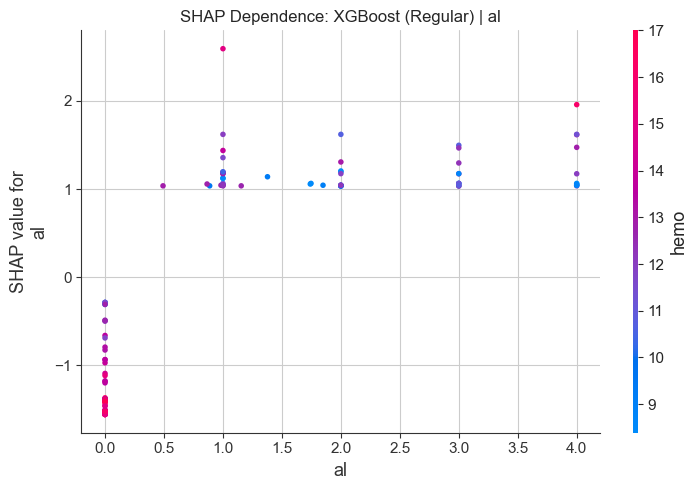

<Figure size 1000x600 with 0 Axes>

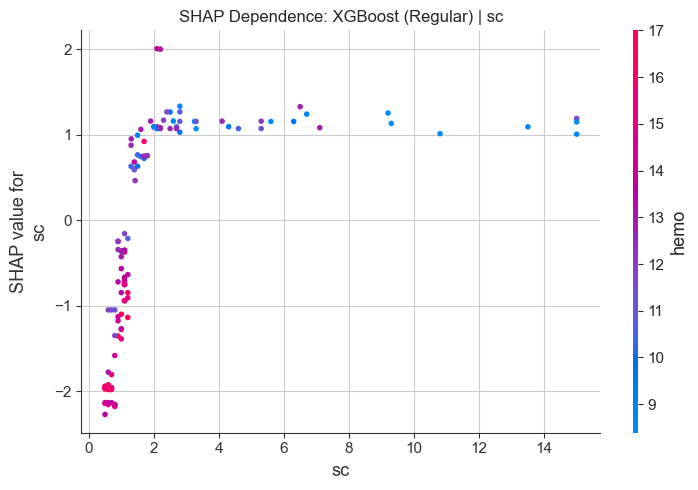


✅ LIME complete for XGBoost (Regular) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


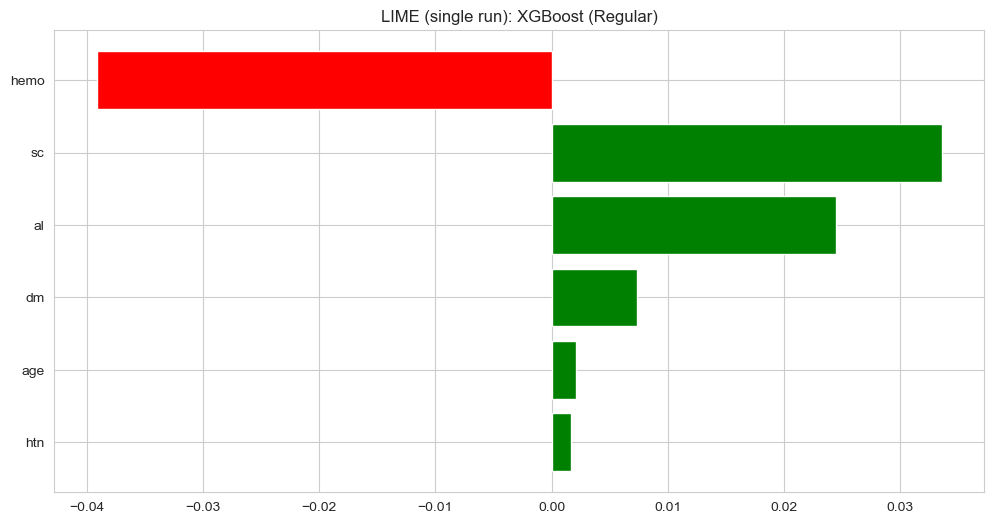

<Figure size 1000x500 with 0 Axes>

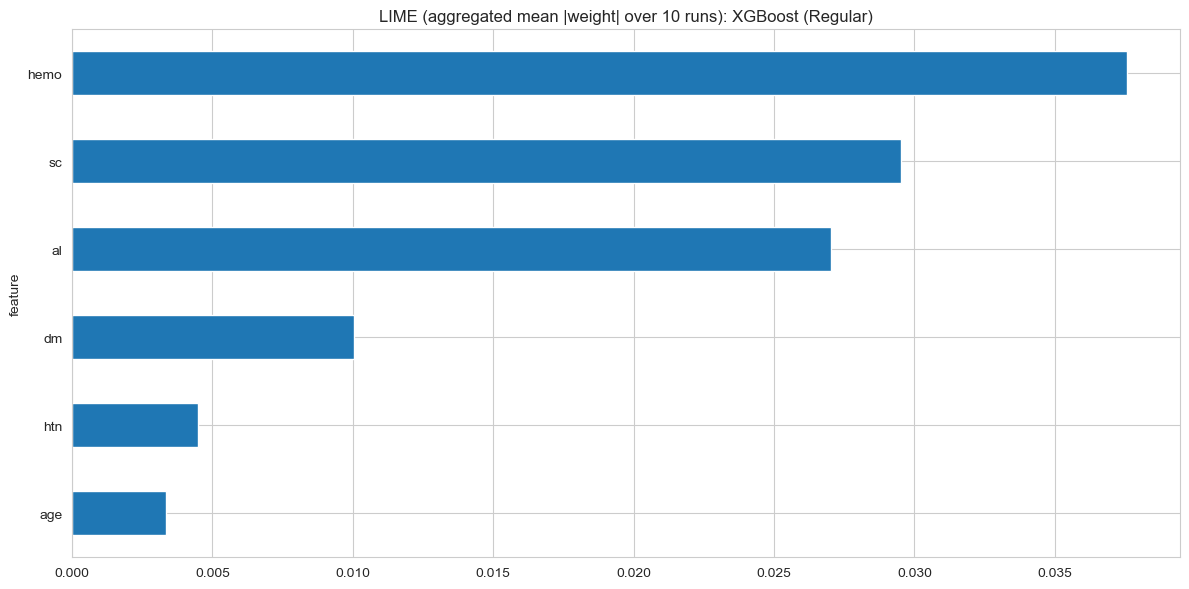


--------------------------------------------------------------------------------
📊 AUGMENTED MODEL (trained with synthetic augmentation)
   Estimator: XGBClassifier | Features (transformed): 6
--------------------------------------------------------------------------------


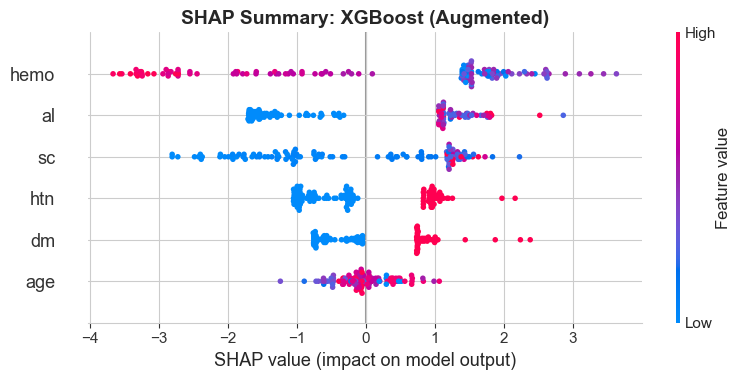

<Figure size 1000x600 with 0 Axes>

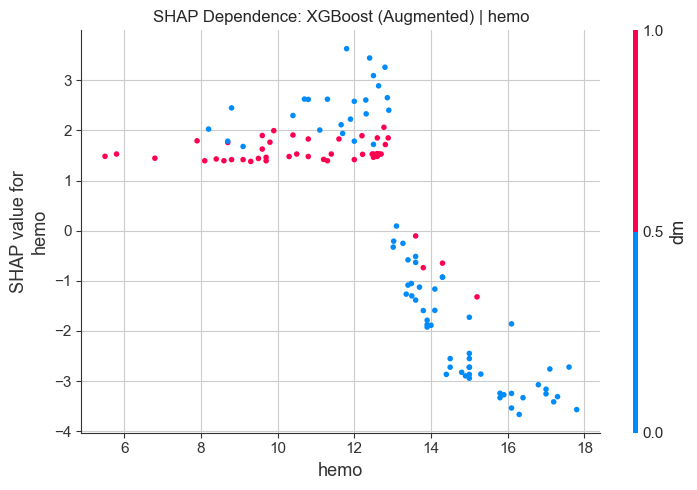

<Figure size 1000x600 with 0 Axes>

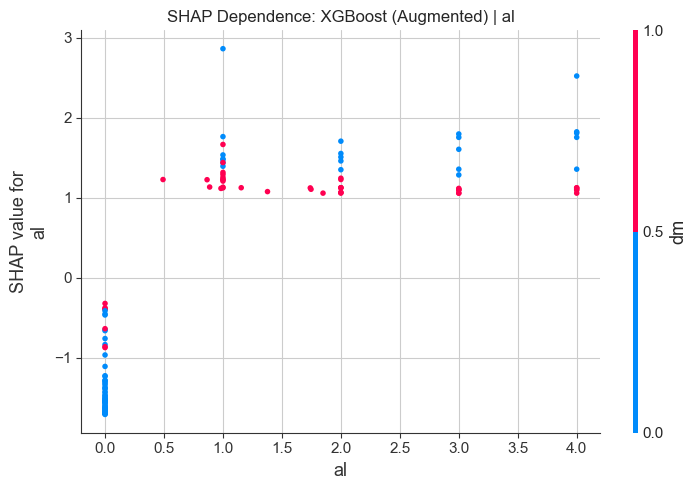

<Figure size 1000x600 with 0 Axes>

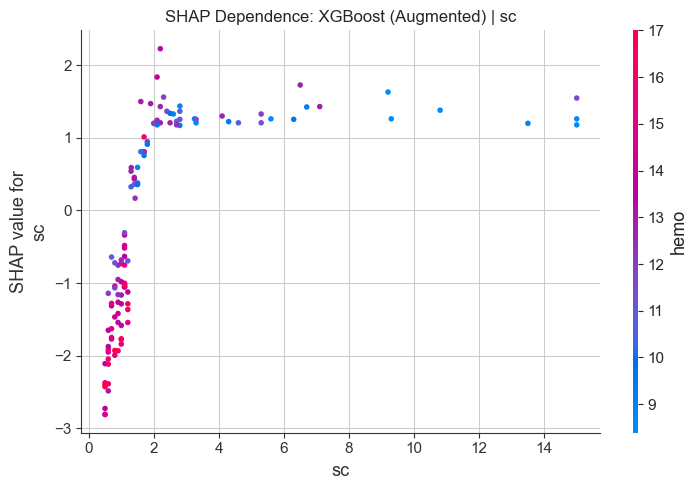


✅ LIME complete for XGBoost (Augmented) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


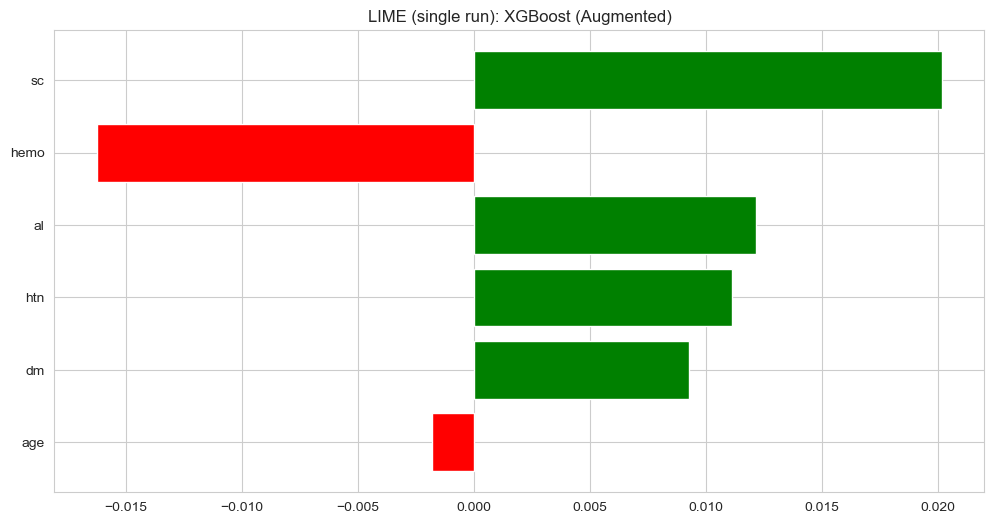

<Figure size 1000x500 with 0 Axes>

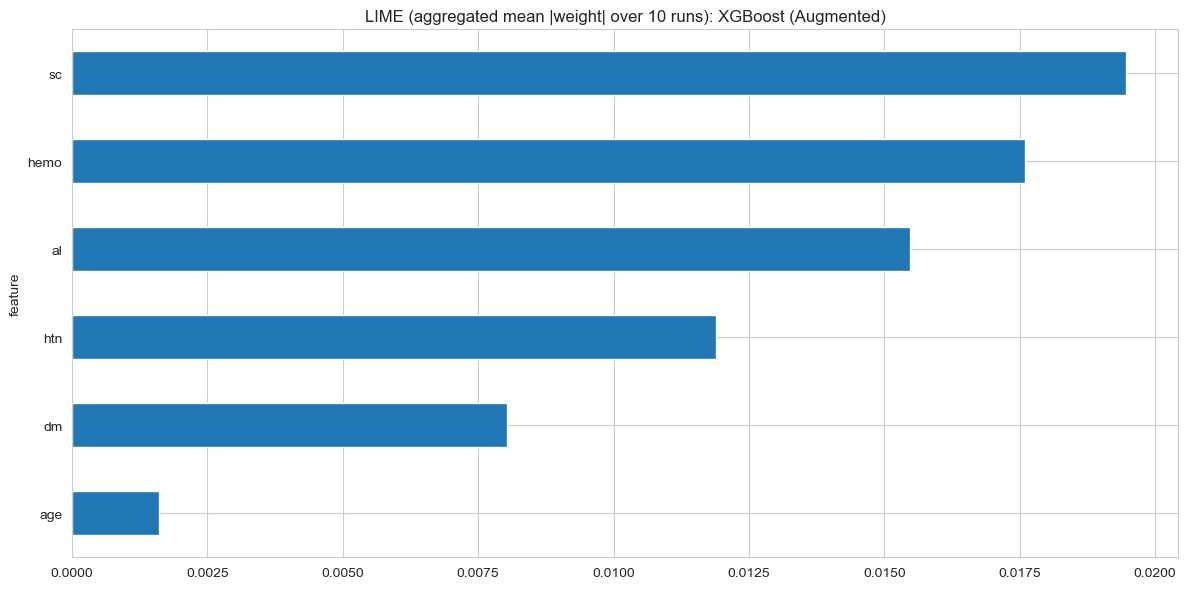


--------------------------------------------------------------------------------
📈 COMPARISON METRICS (aligned clinical features): XGBoost
--------------------------------------------------------------------------------
   Common clinical features: 6
   Top-5 Feature Overlap: 80.0%
   Importance Correlation: 0.9410
   Kendall Tau (Top-10 order): 0.7333
   ESS (Regular):   1.0000
   ESS (Augmented): 1.0000


🔍 MODEL FAMILY: Random Forest

--------------------------------------------------------------------------------
📊 REGULAR MODEL (trained on real data only)
   Estimator: RandomForestClassifier | Features (transformed): 6
--------------------------------------------------------------------------------


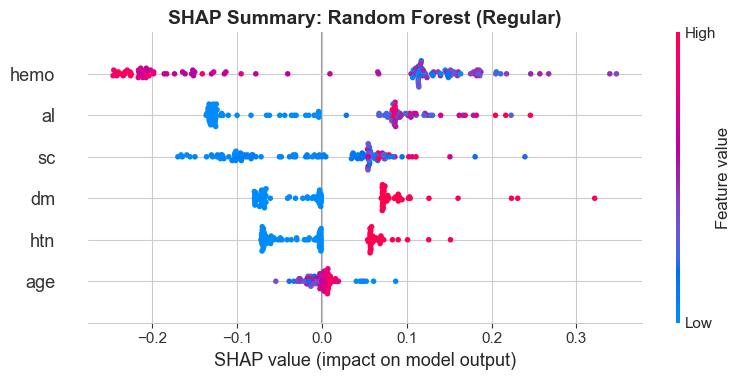

<Figure size 1000x600 with 0 Axes>

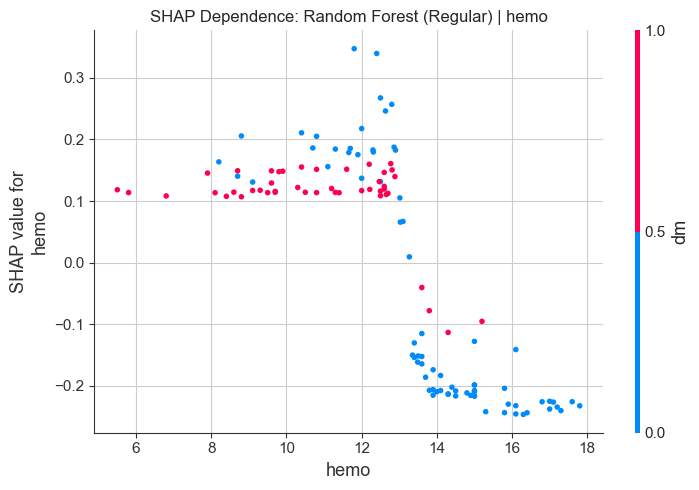

<Figure size 1000x600 with 0 Axes>

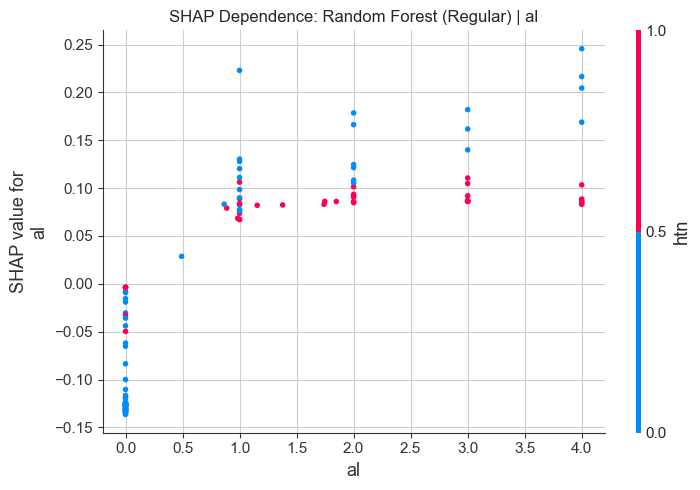

<Figure size 1000x600 with 0 Axes>

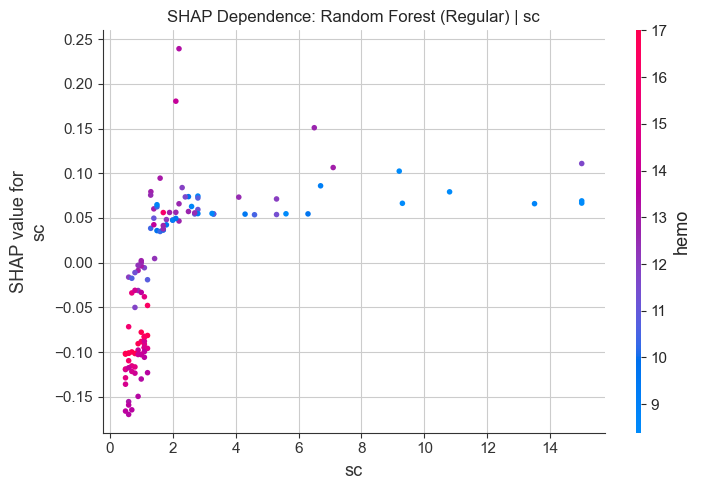


✅ LIME complete for Random Forest (Regular) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


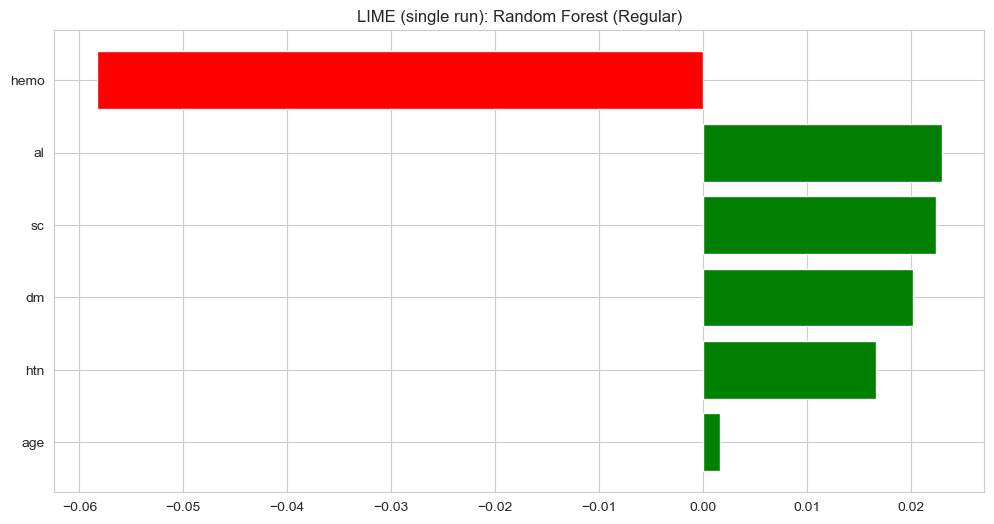

<Figure size 1000x500 with 0 Axes>

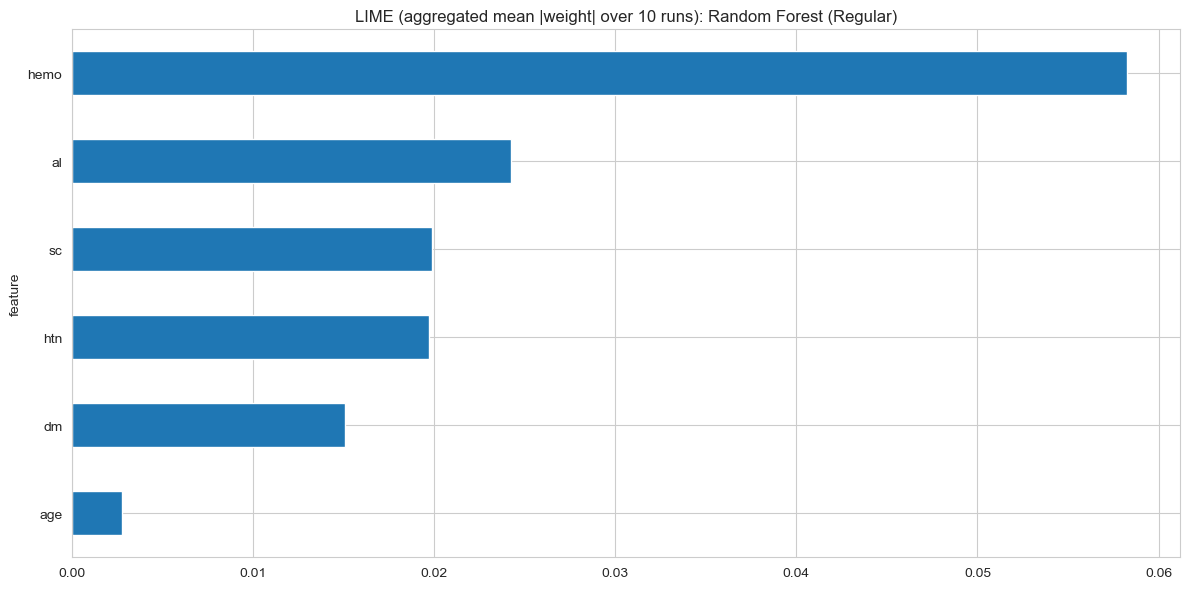


--------------------------------------------------------------------------------
📊 AUGMENTED MODEL (trained with synthetic augmentation)
   Estimator: RandomForestClassifier | Features (transformed): 6
--------------------------------------------------------------------------------


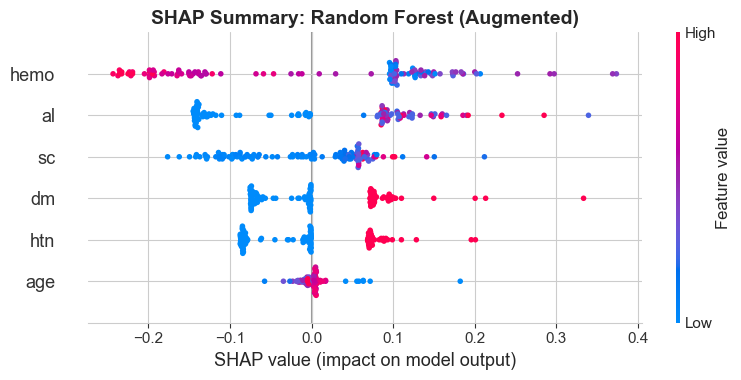

<Figure size 1000x600 with 0 Axes>

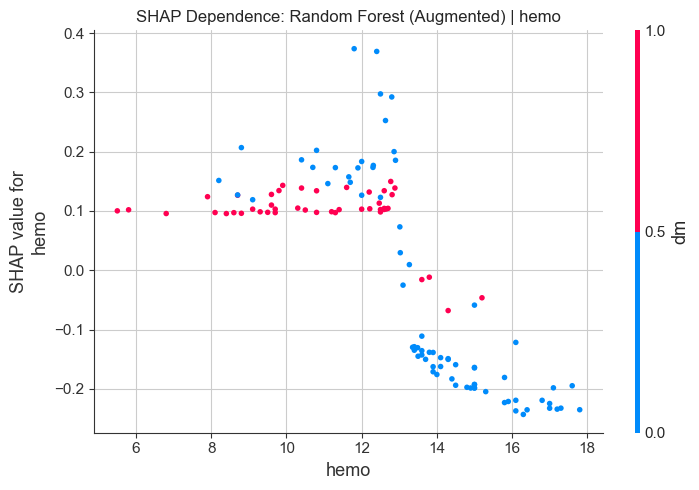

<Figure size 1000x600 with 0 Axes>

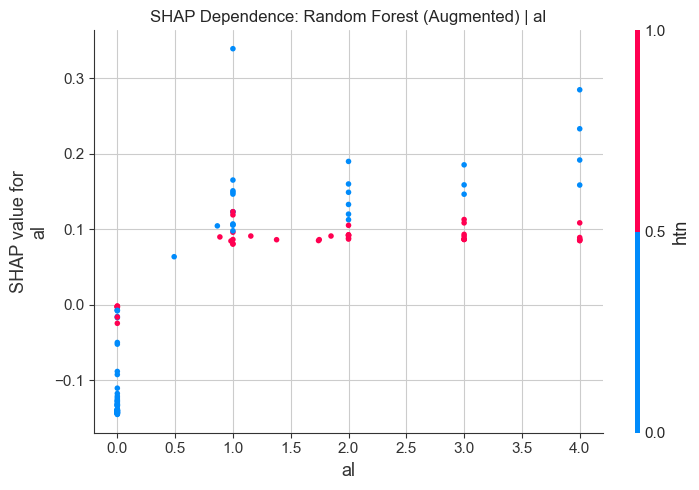

<Figure size 1000x600 with 0 Axes>

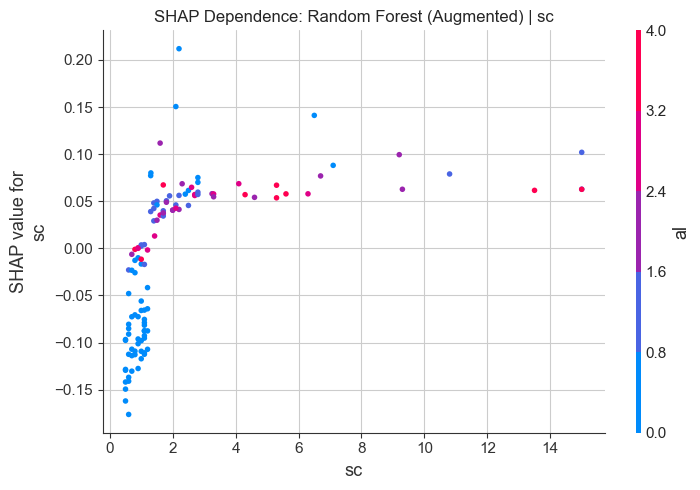


✅ LIME complete for Random Forest (Augmented) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


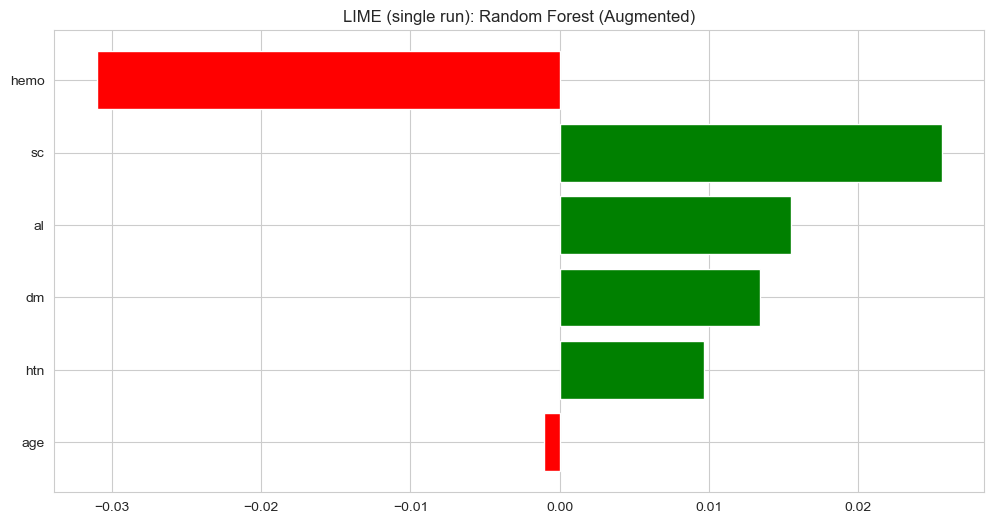

<Figure size 1000x500 with 0 Axes>

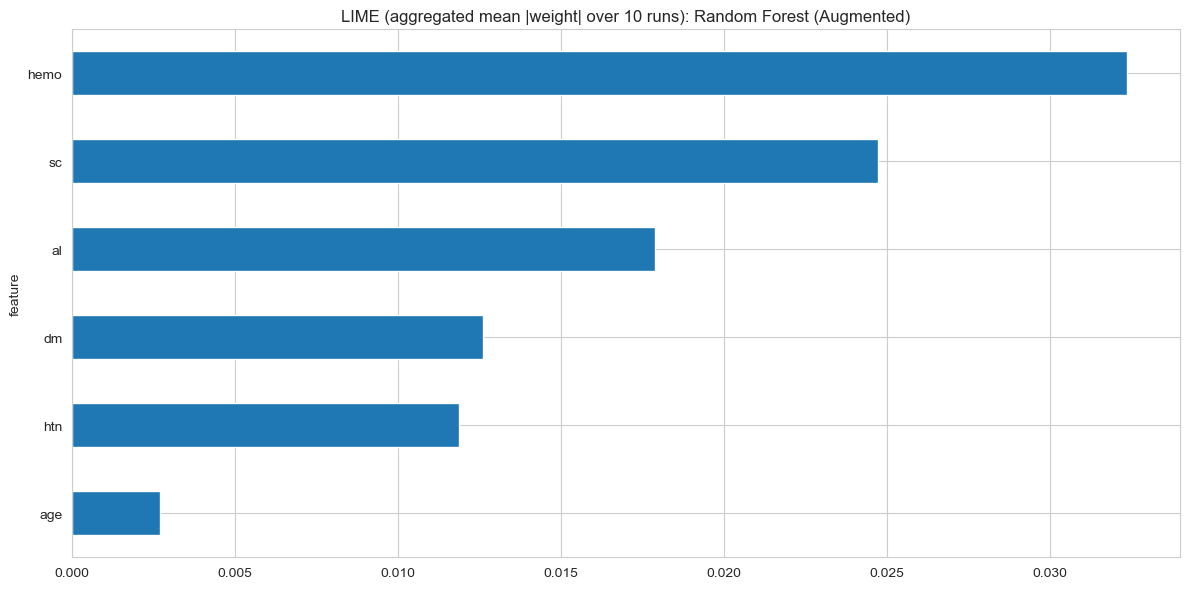


--------------------------------------------------------------------------------
📈 COMPARISON METRICS (aligned clinical features): Random Forest
--------------------------------------------------------------------------------
   Common clinical features: 6
   Top-5 Feature Overlap: 100.0%
   Importance Correlation: 0.9827
   Kendall Tau (Top-10 order): 1.0000
   ESS (Regular):   1.0000
   ESS (Augmented): 1.0000


🔍 MODEL FAMILY: Logistic Regression

--------------------------------------------------------------------------------
📊 REGULAR MODEL (trained on real data only)
   Estimator: LogisticRegression | Features (transformed): 6
--------------------------------------------------------------------------------


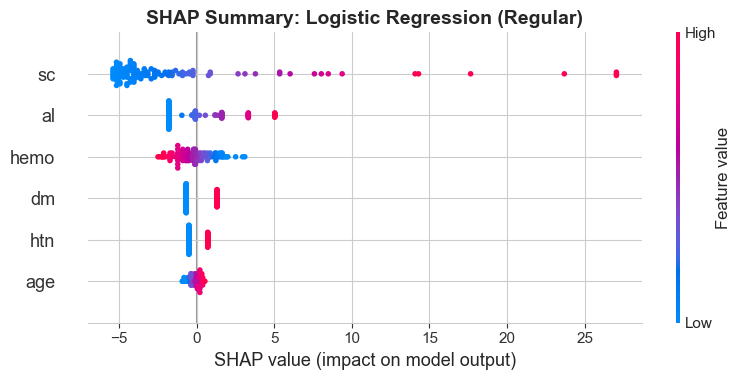

<Figure size 1000x600 with 0 Axes>

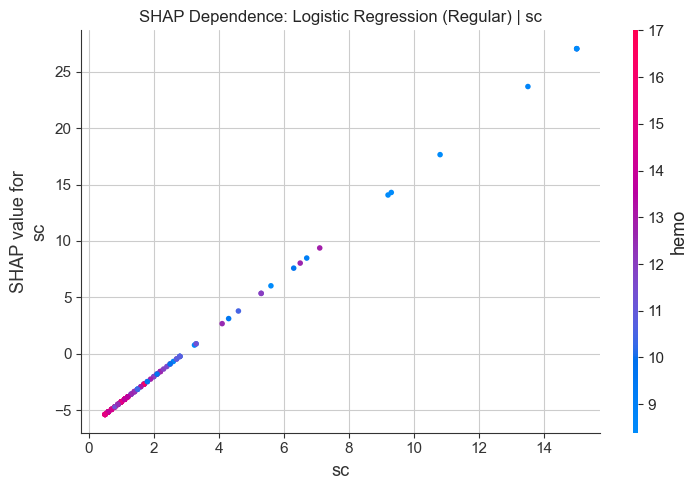

<Figure size 1000x600 with 0 Axes>

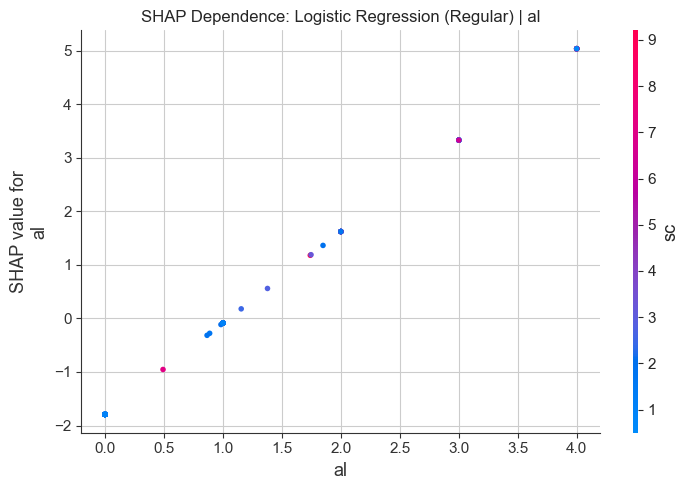

<Figure size 1000x600 with 0 Axes>

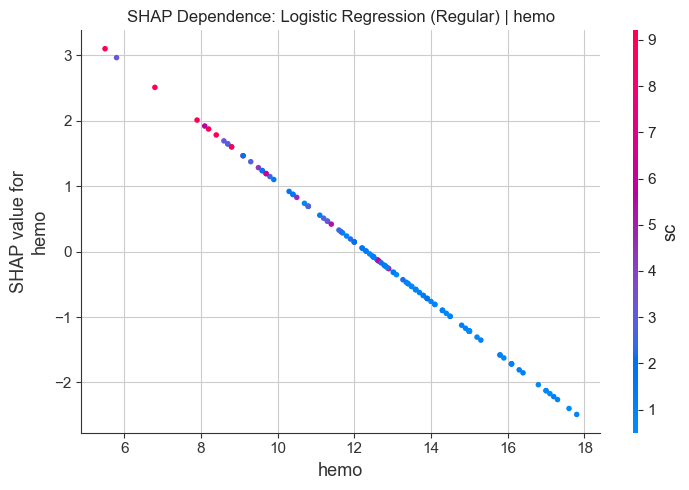


✅ LIME complete for Logistic Regression (Regular) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


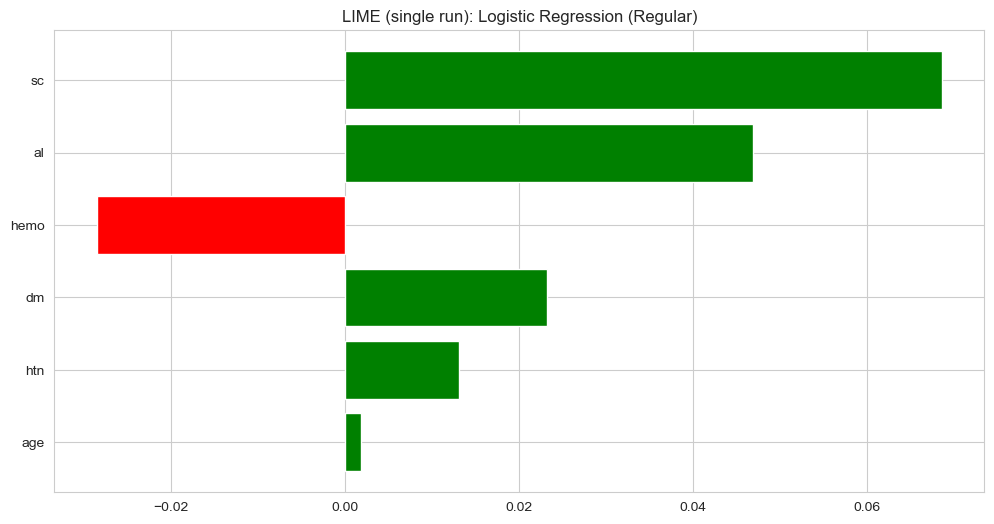

<Figure size 1000x500 with 0 Axes>

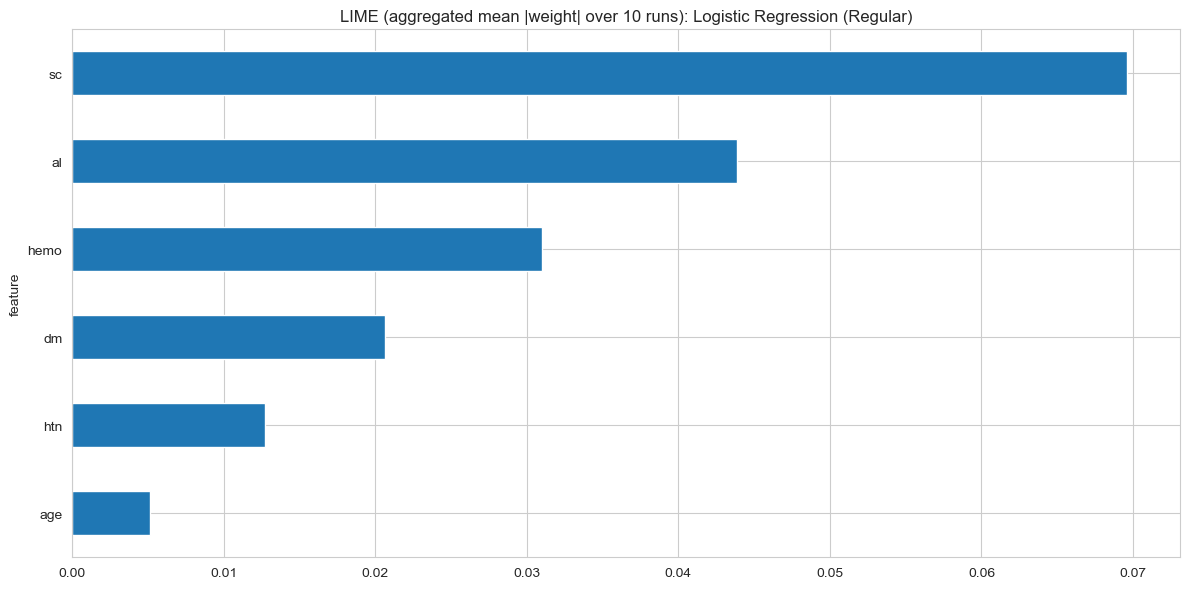


--------------------------------------------------------------------------------
📊 AUGMENTED MODEL (trained with synthetic augmentation)
   Estimator: LogisticRegression | Features (transformed): 6
--------------------------------------------------------------------------------


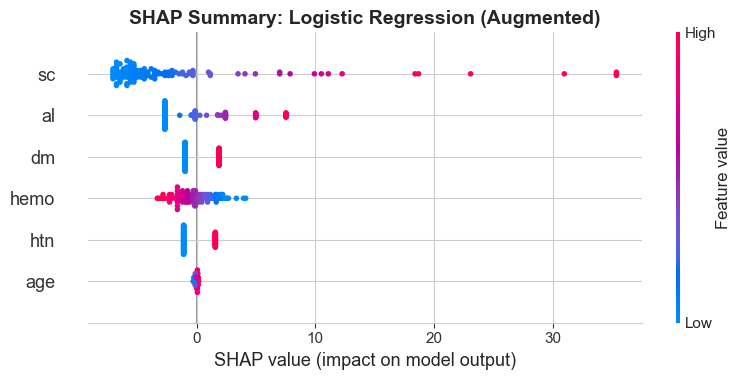

<Figure size 1000x600 with 0 Axes>

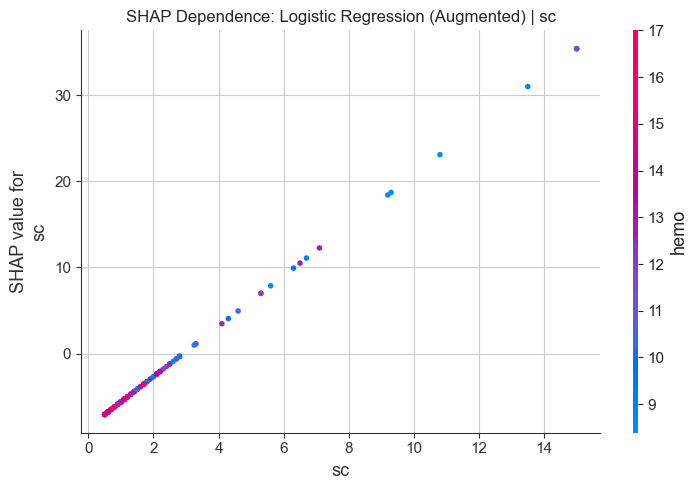

<Figure size 1000x600 with 0 Axes>

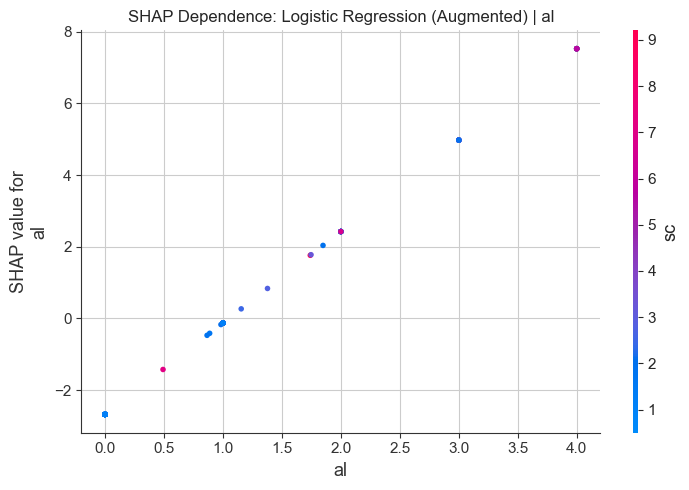

<Figure size 1000x600 with 0 Axes>

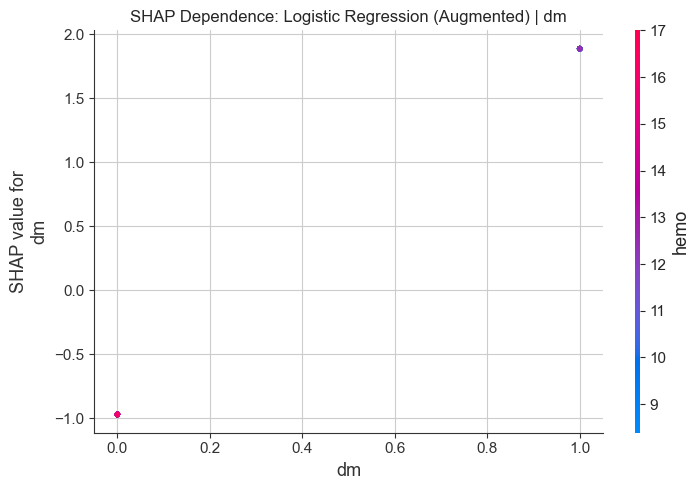


✅ LIME complete for Logistic Regression (Augmented) (sample #0)
   Runs: 10 | Base seed: 42 | Num samples/run: 1000


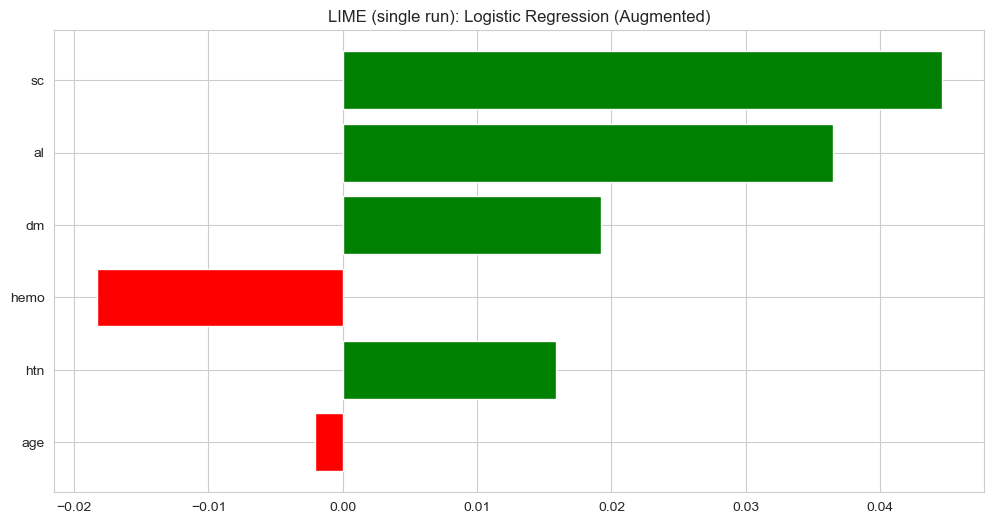

<Figure size 1000x500 with 0 Axes>

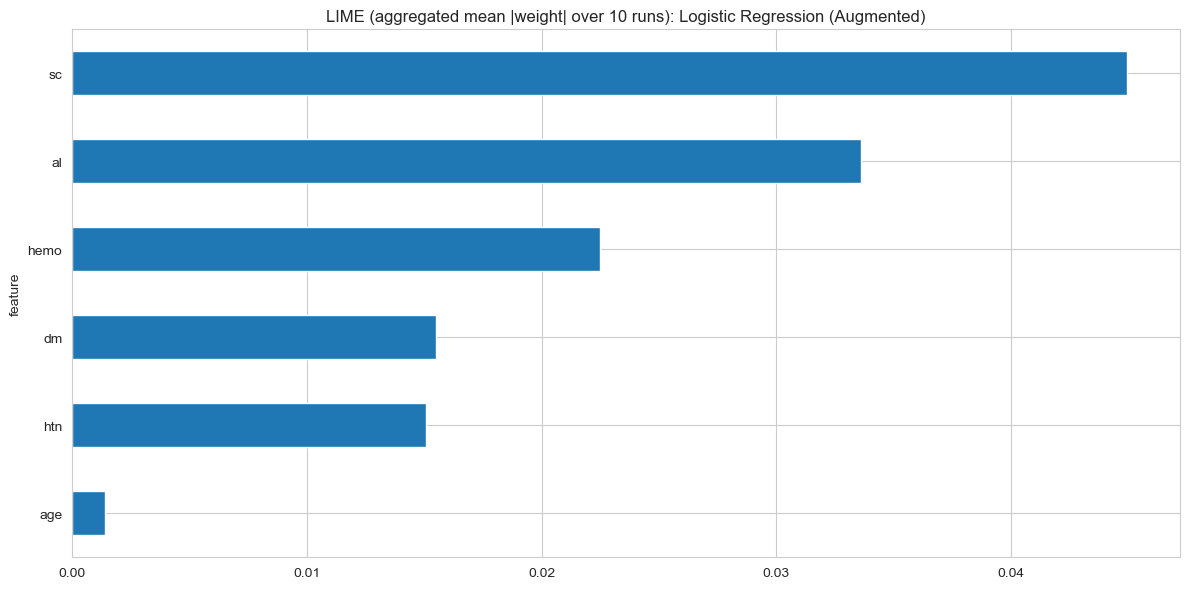


--------------------------------------------------------------------------------
📈 COMPARISON METRICS (aligned clinical features): Logistic Regression
--------------------------------------------------------------------------------
   Common clinical features: 6
   Top-5 Feature Overlap: 100.0%
   Importance Correlation: 0.9920
   Kendall Tau (Top-10 order): 0.8667
   ESS (Regular):   1.0000
   ESS (Augmented): 1.0000


✅ EXPLANATIONS GENERATED SUCCESSFULLY!

📁 All plots saved to: e:\docs\FYP\demo\CKD_Risk_Prediction\results\plots


In [11]:
print("="*80)
print("🚀 STARTING EXPLANATION GENERATION FOR ALL MODELS")
print("="*80)

# Storage for results
results_shap = {}
results_lime = {}
stability_results = []

# Select sample to explain
sample_idx = 0
print(f"\n📍 Explaining sample #{sample_idx} from test set")
print(f"   True label: CKD = {y_test[sample_idx]}")

# Background set (used for SHAP explainers) — canonical raw only
X_background = X_train_canonical.sample(n=min(200, len(X_train_canonical)), random_state=RANDOM_SEED)


def _ensure_pipeline(model, *, kind: str):
    """Ensure we always explain/predict through a Pipeline (preprocess + model).

    After the canonical refactor, model artifacts are typically estimators (not Pipelines),
    so we wrap both regular and augmented variants the same way.
    """
    if hasattr(model, 'named_steps') and 'preprocess' in model.named_steps and 'model' in model.named_steps:
        return model
    return wrap_estimator_as_pipeline(model, X_train_raw)


def _save_lime_figure(exp, title: str, filename: str):
    fig = exp.as_pyplot_figure()
    plt.title(title)
    fig.savefig(RESULTS_DIR / filename, bbox_inches="tight", dpi=200)
    plt.show()


# ========== LOOP THROUGH ALL MODEL FAMILIES ==========
for model_name in models_regular.keys():
    print(f"\n\n{'='*80}")
    print(f"🔍 MODEL FAMILY: {model_name}")
    print(f"{'='*80}")

    # ==================== REGULAR MODEL ====================
    pipeline_regular = _ensure_pipeline(models_regular[model_name], kind='regular')
    est_reg = get_final_estimator(pipeline_regular)
    reg_feat_names = extract_feature_names(pipeline_regular)

    print("\n" + "-"*80)
    print("📊 REGULAR MODEL (trained on real data only)")
    print(f"   Estimator: {type(est_reg).__name__} | Features (transformed): {len(reg_feat_names)}")
    print("-"*80)

    # SHAP (transformed space only)
    shap_reg, Xreg_t, _ = compute_shap_values(pipeline_regular, X_background, X_test_canonical, kernel_kmeans_k=10)
    if shap_reg is None:
        print("⚠️ SHAP failed for regular model; skipping this model family.")
        continue

    results_shap[f"{model_name} (Regular)"] = shap_reg
    plot_shap_summary(
        shap_reg,
        Xreg_t,
        f"SHAP Summary: {model_name} (Regular)",
        save_filename=f"shap_summary__{_slugify_filename(model_name)}__regular.png",
    )
    plot_shap_dependence_top_features(
        shap_reg,
        Xreg_t,
        f"{model_name} (Regular)",
        top_n=3,
        save_prefix="shap_dependence",
    )

    # LIME (N runs + aggregation; prediction uses same pipeline)
    try:
        lime_single_reg, lime_agg_reg = generate_lime_single_and_aggregated(
            pipeline_regular, X_train_canonical, X_test_canonical, f"{model_name} (Regular)",
            sample_idx=sample_idx, n_runs=10, base_seed=RANDOM_SEED, num_features=6, num_samples=1000
        )
        results_lime[f"{model_name} (Regular)"] = {'single': lime_single_reg, 'aggregated': lime_agg_reg}

        _save_lime_figure(
            lime_single_reg,
            f"LIME (single run): {model_name} (Regular)",
            f"lime_single__{_slugify_filename(model_name)}__regular.png",
        )

        plt.figure(figsize=(10, 5))
        lime_agg_reg.head(10).iloc[::-1].plot(kind='barh', x='feature', y='lime_weight_mean_abs', legend=False)
        plt.title(f"LIME (aggregated mean |weight| over 10 runs): {model_name} (Regular)")
        plt.tight_layout()
        save_current_matplotlib_figure(f"lime_agg__{_slugify_filename(model_name)}__regular.png")
        plt.show()
    except Exception as e:
        print(f"⚠️ LIME failed for regular model: {e}")
        lime_single_reg, lime_agg_reg = None, None

    # ESS (within-model stability)
    if 'explanation_stability_score_ess' in globals():
        ess_reg = explanation_stability_score_ess(
            pipeline_regular, X_background, X_test_canonical.iloc[sample_idx], n_perturb=30, noise_frac=0.01
        )
    else:
        ess_reg = float('nan')
        print("⚠️ ESS function not loaded; run Section 7.5 cell to enable ESS.")

    # ==================== AUGMENTED MODEL ====================
    pipeline_augmented = _ensure_pipeline(models_augmented[model_name], kind='augmented')
    est_aug = get_final_estimator(pipeline_augmented)
    aug_feat_names = extract_feature_names(pipeline_augmented)

    print("\n" + "-"*80)
    print("📊 AUGMENTED MODEL (trained with synthetic augmentation)")
    print(f"   Estimator: {type(est_aug).__name__} | Features (transformed): {len(aug_feat_names)}")
    print("-"*80)

    shap_aug, Xaug_t, _ = compute_shap_values(pipeline_augmented, X_background, X_test_canonical, kernel_kmeans_k=10)
    if shap_aug is None:
        print("⚠️ SHAP failed for augmented model; skipping comparison for this family.")
        continue

    results_shap[f"{model_name} (Augmented)"] = shap_aug
    plot_shap_summary(
        shap_aug,
        Xaug_t,
        f"SHAP Summary: {model_name} (Augmented)",
        save_filename=f"shap_summary__{_slugify_filename(model_name)}__augmented.png",
    )
    plot_shap_dependence_top_features(
        shap_aug,
        Xaug_t,
        f"{model_name} (Augmented)",
        top_n=3,
        save_prefix="shap_dependence",
    )

    try:
        lime_single_aug, lime_agg_aug = generate_lime_single_and_aggregated(
            pipeline_augmented, X_train_canonical, X_test_canonical, f"{model_name} (Augmented)",
            sample_idx=sample_idx, n_runs=10, base_seed=RANDOM_SEED, num_features=6, num_samples=1000
        )
        results_lime[f"{model_name} (Augmented)"] = {'single': lime_single_aug, 'aggregated': lime_agg_aug}

        _save_lime_figure(
            lime_single_aug,
            f"LIME (single run): {model_name} (Augmented)",
            f"lime_single__{_slugify_filename(model_name)}__augmented.png",
        )

        plt.figure(figsize=(10, 5))
        lime_agg_aug.head(10).iloc[::-1].plot(kind='barh', x='feature', y='lime_weight_mean_abs', legend=False)
        plt.title(f"LIME (aggregated mean |weight| over 10 runs): {model_name} (Augmented)")
        plt.tight_layout()
        save_current_matplotlib_figure(f"lime_agg__{_slugify_filename(model_name)}__augmented.png")
        plt.show()
    except Exception as e:
        print(f"⚠️ LIME failed for augmented model: {e}")
        lime_single_aug, lime_agg_aug = None, None

    if 'explanation_stability_score_ess' in globals():
        ess_aug = explanation_stability_score_ess(
            pipeline_augmented, X_background, X_test_canonical.iloc[sample_idx], n_perturb=30, noise_frac=0.01
        )
    else:
        ess_aug = float('nan')

    # ==================== REGULAR vs AUGMENTED COMPARISON ====================
    metrics = compute_stability_metrics(shap_reg, reg_feat_names, shap_aug, aug_feat_names, k=5)
    metrics['model'] = model_name
    metrics['ess_regular'] = ess_reg
    metrics['ess_augmented'] = ess_aug
    stability_results.append(metrics)

    print("\n" + "-"*80)
    print(f"📈 COMPARISON METRICS (aligned clinical features): {model_name}")
    print("-"*80)
    print(f"   Common clinical features: {metrics['n_common_features']}")
    print(f"   Top-5 Feature Overlap: {metrics['top_k_overlap']:.1%}" if np.isfinite(metrics['top_k_overlap']) else "   Top-5 Feature Overlap: N/A")
    print(f"   Importance Correlation: {metrics['importance_correlation']:.4f}" if np.isfinite(metrics['importance_correlation']) else "   Importance Correlation: N/A")
    print(f"   Kendall Tau (Top-10 order): {metrics['kendall_tau_top10']:.4f}" if np.isfinite(metrics['kendall_tau_top10']) else "   Kendall Tau (Top-10 order): N/A")
    print(f"   ESS (Regular):   {ess_reg:.4f}" if np.isfinite(ess_reg) else "   ESS (Regular):   N/A")
    print(f"   ESS (Augmented): {ess_aug:.4f}" if np.isfinite(ess_aug) else "   ESS (Augmented): N/A")

print("\n\n" + "="*80)
print("✅ EXPLANATIONS GENERATED SUCCESSFULLY!")
print("="*80)
print(f"\n📁 All plots saved to: {RESULTS_DIR}")

## 9. Comparative Stability Analysis

Now let's visualize and compare the stability of explanations across all models.


📊 EXPLANATION STABILITY COMPARISON

Higher values indicate MORE stable explanations between regular and augmented models.

Stability Metrics Summary:
 top_k_overlap  importance_correlation  kendall_tau_top10  mean_abs_difference  std_abs_difference  n_common_features               model  ess_regular  ess_augmented
           0.8                0.941025           0.733333             0.219653            0.202695                  6             XGBoost          1.0            1.0
           1.0                0.982707           1.000000             0.007747            0.005995                  6       Random Forest          1.0            1.0
           1.0                0.992044           0.866667             0.663405            0.436026                  6 Logistic Regression          1.0            1.0


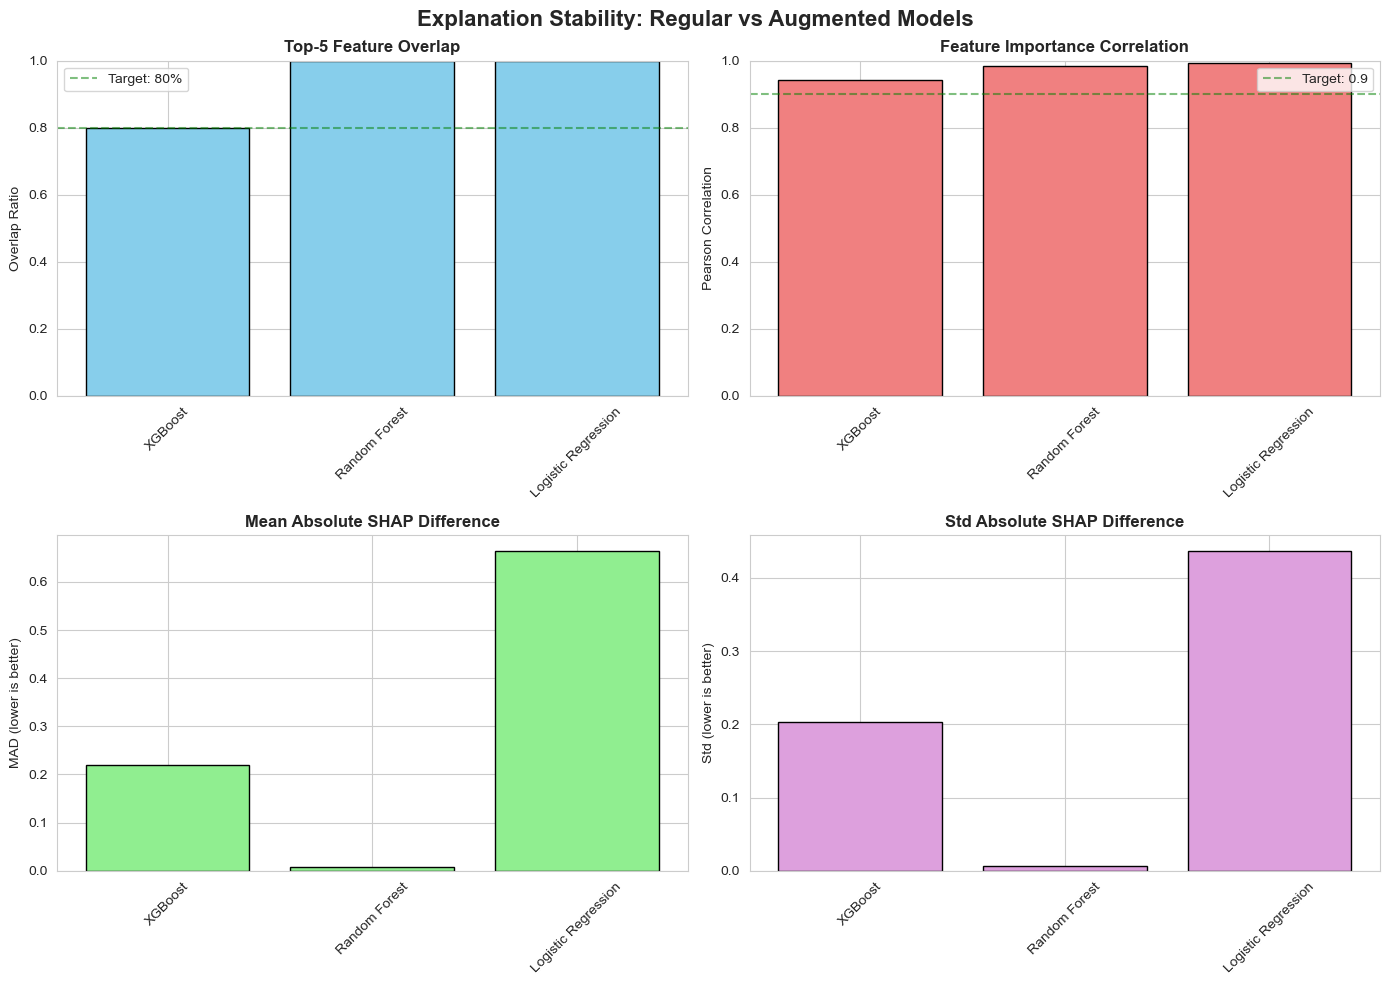


📊 AVERAGE STABILITY ACROSS ALL MODELS

Average Top-5 Overlap: 93.33%
Average Importance Correlation: 0.9719
Average MAD: 0.2969
Average Std: 0.2149


In [12]:
# Create DataFrame from stability results
df_stability = pd.DataFrame(stability_results)

print("\n" + "="*80)
print("📊 EXPLANATION STABILITY COMPARISON")
print("="*80)
print("\nHigher values indicate MORE stable explanations between regular and augmented models.")

if len(df_stability) == 0:
    print("\n⚠️ No stability metrics available yet.")
    print("This may be because:")
    print("   - Augmented models have different preprocessing than regular models")
    print("   - Some models failed to generate SHAP explanations")
    print("\nRunning stability analysis only for successfully compared models...")
else:
    print("\nStability Metrics Summary:")
    print(df_stability.to_string(index=False))

    # Visualize stability metrics
    if len(df_stability) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('Explanation Stability: Regular vs Augmented Models', fontsize=16, fontweight='bold')

        # Top-K Feature Overlap
        axes[0, 0].bar(df_stability['model'], df_stability['top_k_overlap'], color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Top-5 Feature Overlap', fontweight='bold')
        axes[0, 0].set_ylabel('Overlap Ratio')
        axes[0, 0].set_ylim([0, 1])
        axes[0, 0].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Target: 80%')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)

        # Importance Correlation
        axes[0, 1].bar(df_stability['model'], df_stability['importance_correlation'], color='lightcoral', edgecolor='black')
        axes[0, 1].set_title('Feature Importance Correlation', fontweight='bold')
        axes[0, 1].set_ylabel('Pearson Correlation')
        axes[0, 1].set_ylim([0, 1])
        axes[0, 1].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='Target: 0.9')
        axes[0, 1].legend()
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Mean Absolute Difference (lower is better)
        axes[1, 0].bar(df_stability['model'], df_stability['mean_abs_difference'], color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('Mean Absolute SHAP Difference', fontweight='bold')
        axes[1, 0].set_ylabel('MAD (lower is better)')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # Std Absolute Difference (lower is better)
        axes[1, 1].bar(df_stability['model'], df_stability['std_abs_difference'], color='plum', edgecolor='black')
        axes[1, 1].set_title('Std Absolute SHAP Difference', fontweight='bold')
        axes[1, 1].set_ylabel('Std (lower is better)')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Compute and display average metrics
        print("\n" + "="*80)
        print("📊 AVERAGE STABILITY ACROSS ALL MODELS")
        print("="*80)
        print(f"\nAverage Top-5 Overlap: {df_stability['top_k_overlap'].mean():.2%}")
        print(f"Average Importance Correlation: {df_stability['importance_correlation'].mean():.4f}")
        print(f"Average MAD: {df_stability['mean_abs_difference'].mean():.4f}")
        print(f"Average Std: {df_stability['std_abs_difference'].mean():.4f}")


## 10. Explanation Metrics (ESS / ASI / CMC / MEAI / CFS)

This section computes the **reusable, paper-defined metrics** implemented in `src/explanation_metrics.py` using the SHAP values already generated in this notebook.

**Notes:**
- `ESS`/`ASI` require *repeated runs* of the same model. Here we approximate this by recomputing SHAP multiple times with different background samples.
- `CMC_J`/`CMC_A` use SHAP from different model families (e.g., LR/RF/XGB) for the same dataset.
- `MEAI` masks the top-k features (by |SHAP|) for a single instance and measures the relative prediction drop.
- `CFS` is a weighted sum of externally-provided components (P, L, A, S).

In [13]:
from __future__ import annotations

import numpy as np
import pandas as pd

from src.explanation_metrics import compute_all_metrics

# -----------------------------
# Preconditions / guardrails
# -----------------------------
required = ['models_regular', 'models_augmented', 'X_train_canonical', 'X_test_canonical']
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError(
        "Missing required notebook variables. Run the data/model loading sections first. Missing: " + ", ".join(missing)
    )

if 'CANONICAL_FEATURES' not in globals():
    raise NameError("CANONICAL_FEATURES not found. Run the canonical wrapper section first.")

for sym in ['compute_shap_values', 'enforce_clinical_constraints']:
    if sym not in globals():
        raise NameError(f"{sym} not found. Run the SHAP + canonical wrapper sections first.")

seed0 = int(globals().get('RANDOM_SEED', 42))
sample_idx = int(globals().get('sample_idx', 0))  # default to first test instance
print(f"Using sample_idx={sample_idx}")

def _as4(name: str, x) -> tuple[float, float, float, float]:
    if not isinstance(x, (tuple, list)) or len(x) != 4:
        raise ValueError(f"{name} must be a tuple/list of length 4; got {x!r}")
    return (float(x[0]), float(x[1]), float(x[2]), float(x[3]))

def _ensure_pipeline_local(model):
    # If it's already a Pipeline with preprocess+model, keep it.
    if hasattr(model, 'named_steps') and 'preprocess' in model.named_steps and 'model' in model.named_steps:
        return model
    if 'wrap_estimator_as_pipeline' not in globals():
        raise NameError("wrap_estimator_as_pipeline not found. Run the canonical wrapper section first.")
    if 'X_train_raw' not in globals():
        raise NameError("X_train_raw not found. Run the data loading section first.")
    return wrap_estimator_as_pipeline(model, X_train_raw)

# -----------------------------
# Shared MEAI setup (same instance x, same baseline fill)
# -----------------------------
feature_names = list(CANONICAL_FEATURES)
x0 = X_test_canonical.iloc[int(sample_idx)].copy()
baseline_fill = X_train_canonical[feature_names].median(numeric_only=True).to_dict()

def mask_fn(x, features):
    if isinstance(x, pd.Series):
        xx = x.reindex(feature_names).copy()
    elif isinstance(x, dict):
        xx = pd.Series(x).reindex(feature_names)
    else:
        x_arr = np.asarray(x, dtype=float).reshape(-1)
        xx = pd.Series({feature_names[i]: x_arr[i] for i in range(len(feature_names))})
    for f in features:
        if f in xx.index:
            xx[f] = float(baseline_fill.get(f, 0.0))
    return xx

# -----------------------------
# CFS inputs (external components in [0,1])
# -----------------------------
CFS_COMPONENTS = _as4('CFS_COMPONENTS', globals().get('CFS_COMPONENTS', (0.0, 0.0, 0.0, 0.0)))
CFS_WEIGHTS = _as4('CFS_WEIGHTS', globals().get('CFS_WEIGHTS', (0.25, 0.25, 0.25, 0.25)))

# -----------------------------
# Per-variant computation
# -----------------------------
if 'results_shap' not in globals():
    results_shap = {}

def _compute_variant(variant: str, models_dict: dict) -> dict:
    # Ensure SHAP cache for this variant (one run per model family)
    have_any = any(k.endswith(f'({variant})') for k in results_shap.keys())
    if not have_any:
        print(f"No cached SHAP found for variant={variant!r}; recomputing SHAP once per model family (no plots)...")
        X_bg0 = X_train_canonical.sample(n=min(200, len(X_train_canonical)), random_state=seed0)
        for model_name, model_obj in models_dict.items():
            pipe = _ensure_pipeline_local(model_obj)
            sh, _, _ = compute_shap_values(pipe, X_bg0, X_test_canonical, kernel_kmeans_k=10)
            if sh is None:
                print(f"  ⚠️ SHAP failed for {model_name}; skipping")
                continue
            results_shap[f"{model_name} ({variant})"] = np.asarray(sh, dtype=float)
        print("Done.")

    # shap_models across different model families
    model_families = sorted({k.split(' (')[0] for k in results_shap.keys() if k.endswith(f'({variant})')})
    if len(model_families) < 2:
        raise ValueError(f"Need at least 2 model families with SHAP for variant={variant!r}. Found: {model_families}")

    shap_models_list: list[np.ndarray] = []
    for mf in model_families:
        key = f"{mf} ({variant})"
        arr = np.asarray(results_shap[key], dtype=float)
        if arr.ndim != 2:
            raise ValueError(f"results_shap[{key!r}] must have shape (n_samples, d); got {arr.shape}")
        shap_models_list.append(arr)

    shap_models = np.stack(shap_models_list, axis=0)  # (M, n, d)
    M, n, d = shap_models.shape
    if d != len(feature_names):
        # Try aligning to canonical columns if SHAP returned a different order
        aligned_names = list(X_test_canonical.columns)
        if d != len(aligned_names):
            raise ValueError(f"SHAP dim d={d} does not match canonical feature_names length={len(feature_names)}")
        # Keep feature_names as canonical; arrays are assumed canonical-compatible
        # (If they aren't, compute_shap_values should be adjusted upstream.)

    # shap_runs: repeated SHAP runs for one chosen model in this variant
    preferred = 'Random Forest' if 'Random Forest' in models_dict else next(iter(models_dict.keys()))
    pipeline_chosen = _ensure_pipeline_local(models_dict[preferred])

    def pred_fn(x):
        if isinstance(x, pd.Series):
            X = x.to_frame().T
        elif isinstance(x, pd.DataFrame):
            X = x.copy()
        elif isinstance(x, dict):
            X = pd.DataFrame([x])
        else:
            x_arr = np.asarray(x, dtype=float).reshape(-1)
            X = pd.DataFrame([x_arr], columns=feature_names)
        X = X.reindex(columns=feature_names)
        X = enforce_clinical_constraints(X, strict=False)
        proba = pipeline_chosen.predict_proba(X)
        proba = np.asarray(proba, dtype=float)
        return float(proba[0, 1])

    n_runs = 10
    shap_runs_list: list[np.ndarray] = []
    for r in range(n_runs):
        X_bg = X_train_canonical.sample(n=min(200, len(X_train_canonical)), random_state=seed0 + r)
        sh, _, fnames = compute_shap_values(pipeline_chosen, X_bg, X_test_canonical, kernel_kmeans_k=10)
        if sh is None:
            raise RuntimeError(f"SHAP recomputation failed for variant={variant!r}, run={r}")
        sh = np.asarray(sh, dtype=float)
        if sh.shape != (n, d):
            if fnames is None:
                raise ValueError(f"Unexpected SHAP shape {sh.shape} and missing feature names for alignment")
            sh_df = pd.DataFrame(sh, columns=list(fnames))
            sh = sh_df.reindex(columns=feature_names).fillna(0.0).to_numpy(dtype=float)
        shap_runs_list.append(sh)

    shap_runs = np.stack(shap_runs_list, axis=0)  # (R, n, d)

    # D_max: safe upper bound for L1 distances (variant-specific)
    combined = np.concatenate([shap_runs.reshape(-1, d), shap_models.reshape(-1, d)], axis=0)
    ranges = np.max(combined, axis=0) - np.min(combined, axis=0)
    D_max = float(np.sum(ranges))
    D_max = max(D_max, 1e-12)
    print(f"[{variant}] Using D_max={D_max:.6g}")

    metrics = compute_all_metrics(
        shap_runs=shap_runs,
        shap_models=shap_models,
        feature_names=feature_names,
        pred_fn=pred_fn,
        mask_fn=mask_fn,
        x=x0,
        k=3,
        D_max=D_max,
        cfs_components=CFS_COMPONENTS,
        cfs_weights=CFS_WEIGHTS,
        sample_index=int(sample_idx),
    )

    row = {
        'variant': variant,
        'model_for_runs': preferred,
        'n_runs': int(n_runs),
        'n_models': int(M),
        'sample_idx': int(sample_idx),
        **metrics,
    }
    return row

rows = [
    _compute_variant('Regular', models_regular),
    _compute_variant('Augmented', models_augmented),
 ]

df_metrics = pd.DataFrame(rows)
print("\nAcademic explanation metrics (Regular vs Augmented):")
display(df_metrics)


Using sample_idx=0
[Regular] Using D_max=51.6888
[Augmented] Using D_max=69.3396

Academic explanation metrics (Regular vs Augmented):


,variant,model_for_runs,n_runs,n_models,sample_idx,ESS,ASI,CMC_J,CMC_A,MEAI,CFS
0,Regular,Random Forest,10,3,0,0.975979,0.998932,0.660,0.858490,0.015,0.0
1,Augmented,Random Forest,10,3,0,0.959894,0.999195,0.605,0.862258,0.035,0.0


## 10.1 Stability Analysis of Local Surrogate Explanations (LIME)

This subsection reports **LIME-specific stability** for the same test instance across repeated LIME runs (do not mix with SHAP ESS/ASI).

Reported metrics:
- **LFSS**: Top‑K (by |weight|) overlap stability (Jaccard) across runs
- **LRS**: Rank stability (Spearman on |weight| ranks) across runs
- **LSC**: Sign consistency for Top‑K features across runs

In [ ]:
from __future__ import annotations

import importlib
import numpy as np
import pandas as pd

# Auto-reload in case the kernel imported an older version before edits
import src.explanation_metrics as _exm
importlib.reload(_exm)
compute_lime_stability_metrics = _exm.compute_lime_stability_metrics

# Preconditions
required = ['models_regular', 'models_augmented', 'X_train_raw', 'X_test_raw']
missing = [k for k in required if k not in globals()]
if missing:
    raise NameError("Missing required notebook variables. Run the data/model loading sections first. Missing: " + ", ".join(missing))

if 'LimeTabularExplainer' not in globals():
    from lime.lime_tabular import LimeTabularExplainer

if 'enforce_clinical_constraints' not in globals():
    raise NameError("enforce_clinical_constraints not found. Run the canonical wrapper section first.")

if 'wrap_estimator_as_pipeline' not in globals():
    raise NameError("wrap_estimator_as_pipeline not found. Run the canonical wrapper section first.")

seed0 = int(globals().get('RANDOM_SEED', 42))
sample_idx = int(globals().get('sample_idx', 0))
print(f"Using sample_idx={sample_idx}")

def _ensure_pipeline(model):
    if hasattr(model, 'named_steps') and 'preprocess' in model.named_steps and 'model' in model.named_steps:
        return model
    return wrap_estimator_as_pipeline(model, X_train_raw)

def _encode_for_lime(X_train: pd.DataFrame, X_test: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, dict[str, dict[int, object]], list[int], dict[int, list[object]]]:
    """Encode raw data into numeric arrays LIME can scale, while keeping a decoder for predict_fn."""
    raw_cols = X_train.columns.tolist()
    Xtr = X_train.copy()
    Xte = X_test.copy()

    decoder: dict[str, dict[int, object]] = {}  # col -> {code: original_value}
    categorical_features: list[int] = []
    categorical_names: dict[int, list[object]] = {}  # feature_index -> list of original values by code

    for j, col in enumerate(raw_cols):
        s = Xtr[col]
        # Treat non-numeric as categorical for LIME
        if not pd.api.types.is_numeric_dtype(s):
            cats = pd.Series(pd.concat([Xtr[col], Xte[col]], axis=0)).astype('object').fillna('<<MISSING>>')
            uniq = list(pd.unique(cats))
            # Stable order: keep first-seen order from concatenation
            mapping = {val: i for i, val in enumerate(uniq)}
            inv = {i: val for val, i in mapping.items()}
            decoder[col] = inv
            categorical_features.append(j)
            categorical_names[j] = uniq
            Xtr[col] = Xtr[col].astype('object').fillna('<<MISSING>>').map(mapping).astype(int)
            Xte[col] = Xte[col].astype('object').fillna('<<MISSING>>').map(mapping).astype(int)
        else:
            # Ensure float for scaler; allow NaN and fill with median for LIME's training_data stats
            Xtr[col] = pd.to_numeric(Xtr[col], errors='coerce')
            Xte[col] = pd.to_numeric(Xte[col], errors='coerce')
            med = float(np.nanmedian(Xtr[col].to_numpy(dtype=float))) if np.isfinite(np.nanmedian(Xtr[col].to_numpy(dtype=float))) else 0.0
            Xtr[col] = Xtr[col].fillna(med).astype(float)
            Xte[col] = Xte[col].fillna(med).astype(float)

    return Xtr, Xte, decoder, categorical_features, categorical_names

def _decode_lime_matrix(X_num: pd.DataFrame, decoder: dict[str, dict[int, object]]) -> pd.DataFrame:
    """Convert numeric-coded LIME matrix back into raw-space values for the pipeline."""
    X = X_num.copy()
    for col, inv in decoder.items():
        # Round/clip to valid integer codes before mapping
        codes = np.asarray(X[col], dtype=float)
        codes = np.rint(codes).astype(int)
        lo = int(np.min(list(inv.keys())))
        hi = int(np.max(list(inv.keys())))
        codes = np.clip(codes, lo, hi)
        X[col] = pd.Series(codes, index=X.index).map(inv)
        # Restore missing sentinel to actual NaN
        X.loc[X[col] == '<<MISSING>>', col] = np.nan
    return X

def _lime_weight_matrix(
    pipeline,
    *,
    n_runs: int = 10,
    base_seed: int = 42,
    num_features: int = 10,
    num_samples: int = 1000,
    class_names=('No CKD', 'CKD'),
 ) -> tuple[np.ndarray, list[str]]:
    if n_runs < 2:
        raise ValueError("Need n_runs >= 2")

    raw_cols = X_train_raw.columns.tolist()
    X_train_lime, X_test_lime, decoder, categorical_features, categorical_names = _encode_for_lime(X_train_raw, X_test_raw)
    sample = X_test_lime.iloc[int(sample_idx)].to_numpy(dtype=float)

    def predict_fn(x):
        X_num = x
        if not isinstance(X_num, pd.DataFrame):
            X_num = pd.DataFrame(X_num, columns=raw_cols)
        # Decode categorical codes back to raw values expected by the pipeline
        X_raw = _decode_lime_matrix(X_num, decoder)
        X_raw = enforce_clinical_constraints(X_raw, strict=False)
        if 'apply_clinical_bounds' in globals() and globals().get('apply_clinical_bounds') is not None:
            try:
                X_raw = apply_clinical_bounds(X_raw)
            except Exception:
                pass
        return pipeline.predict_proba(X_raw)

    W = np.zeros((int(n_runs), len(raw_cols)), dtype=float)
    for i in range(int(n_runs)):
        explainer = LimeTabularExplainer(
            training_data=X_train_lime.to_numpy(dtype=float),
            feature_names=raw_cols,
            class_names=list(class_names),
            mode='classification',
            random_state=int(base_seed) + i,
            discretize_continuous=False,
            categorical_features=categorical_features,
            categorical_names=categorical_names,
        )
        exp = explainer.explain_instance(
            data_row=sample,
            predict_fn=predict_fn,
            num_features=int(num_features),
            num_samples=int(num_samples),
            labels=(1,),
        )
        local = dict(exp.local_exp[1])  # {feature_index: weight}
        for j, w in local.items():
            if 0 <= int(j) < W.shape[1]:
                W[i, int(j)] = float(w)

    return W, raw_cols

def _compute_variant(variant: str, models_dict: dict, *, topk_k: int = 3) -> dict:
    preferred = 'Random Forest' if 'Random Forest' in models_dict else next(iter(models_dict.keys()))
    pipeline = _ensure_pipeline(models_dict[preferred])

    W, raw_cols = _lime_weight_matrix(
        pipeline,
        n_runs=10,
        base_seed=seed0,
        num_features=10,
        num_samples=1000,
    )
    lime_metrics = compute_lime_stability_metrics(W, k=int(topk_k))
    return {
        'variant': variant,
        'model_for_lime': preferred,
        'n_runs': int(W.shape[0]),
        'd_features_raw': int(W.shape[1]),
        'topk_k': int(topk_k),
        **lime_metrics,
    }

rows = [
    _compute_variant('Regular', models_regular, topk_k=3),
    _compute_variant('Augmented', models_augmented, topk_k=3),
 ]

df_lime_stability = pd.DataFrame(rows)
print("\nLIME stability metrics (LFSS/LRS/LSC):")
display(df_lime_stability)

Using sample_idx=0

LIME stability metrics (LFSS/LRS/LSC):


,variant,model_for_lime,n_runs,d_features_raw,topk_k,LFSS,LRS,LSC
0,Regular,Random Forest,10,24,3,1.0,0.798013,1.0
1,Augmented,Random Forest,10,24,3,1.0,0.766968,1.0


,variant,model_for_lime,n_runs,d_features_raw,topk_k,LFSS,LRS,LSC
0,Regular,Random Forest,10,24,3,1.0,0.798013,1.0
1,Augmented,Random Forest,10,24,3,1.0,0.766968,1.0


## 11. Export Results

Save stability metrics for reporting or further analysis.

In [18]:
# Save all generated metrics (stability + academic SHAP metrics + LIME stability)
from pathlib import Path

out_dir = Path(PROJECT_ROOT) / 'results'
out_dir.mkdir(parents=True, exist_ok=True)

saved = {}

def _save_df(name: str, df, filename: str):
    if df is None:
        return
    try:
        df.to_csv(out_dir / filename, index=False)
        saved[name] = str(out_dir / filename)
    except Exception as e:
        raise RuntimeError(f"Failed saving {name} to {filename}: {e}") from e

# 1) Existing SHAP stability comparison table (regular vs augmented)
_save_df('stability_metrics', globals().get('df_stability'), 'explanation_stability_metrics.csv')

# 2) Academic SHAP metrics (ESS/ASI/CMC/MEAI/CFS), Regular + Augmented rows
_save_df('academic_shap_metrics', globals().get('df_metrics'), 'explanation_metrics.csv')

# 3) LIME stability metrics (LFSS/LRS/LSC), Regular + Augmented rows
_save_df('lime_stability_metrics', globals().get('df_lime_stability'), 'lime_stability_metrics.csv')

# 4) Optional combined one-row-per-variant view (if both exist)
df_metrics = globals().get('df_metrics')
df_lime = globals().get('df_lime_stability')
if df_metrics is not None and df_lime is not None and 'variant' in df_metrics.columns and 'variant' in df_lime.columns:
    df_all = df_metrics.merge(df_lime, on='variant', how='outer', suffixes=('_shap', '_lime'))
    _save_df('all_metrics', df_all, 'all_explanation_metrics.csv')

print("✅ Saved metrics files:")
for k, v in saved.items():
    print(f"  - {k}: {v}")
print("\n📁 Results saved successfully!")

✅ Saved metrics files:
  - academic_shap_metrics: e:\docs\FYP\demo\CKD_Risk_Prediction\results\explanation_metrics.csv
  - lime_stability_metrics: e:\docs\FYP\demo\CKD_Risk_Prediction\results\lime_stability_metrics.csv
  - all_metrics: e:\docs\FYP\demo\CKD_Risk_Prediction\results\all_explanation_metrics.csv

📁 Results saved successfully!


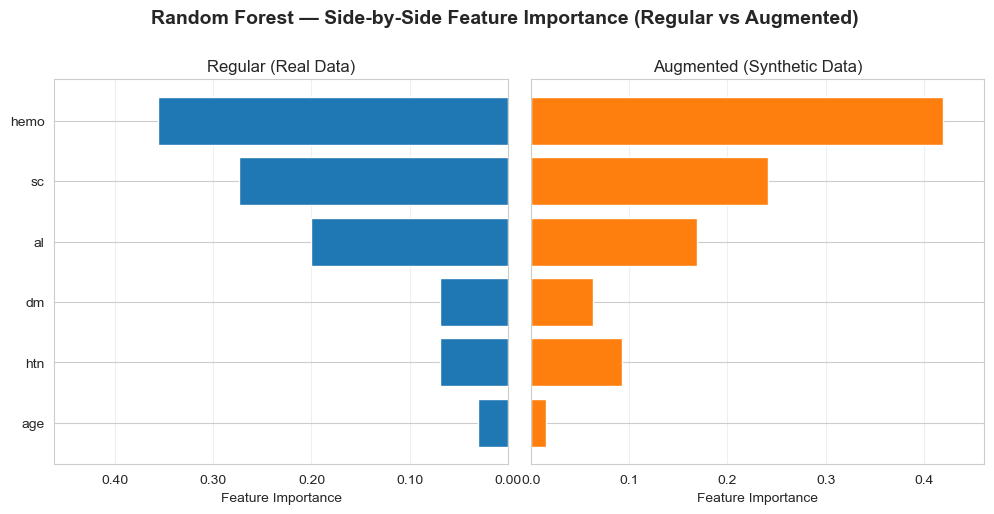

In [14]:
# Side-by-Side (Mirrored) Feature Importance — Random Forest (Regular vs Augmented)
if 'models_regular' not in globals() or 'models_augmented' not in globals():
    raise NameError("models_regular/models_augmented not found. Run the 'Load Models' section first.")

if 'Random Forest' not in models_regular or 'Random Forest' not in models_augmented:
    raise KeyError("Random Forest not found in loaded model dictionaries.")

# Ensure we explain through the same canonical preprocessing pipeline
pipeline_rf_regular = _ensure_pipeline(models_regular['Random Forest'], kind='regular')
pipeline_rf_augmented = _ensure_pipeline(models_augmented['Random Forest'], kind='augmented')

est_rf_regular = get_final_estimator(pipeline_rf_regular)
est_rf_augmented = get_final_estimator(pipeline_rf_augmented)

feat_regular = extract_feature_names(pipeline_rf_regular)
feat_augmented = extract_feature_names(pipeline_rf_augmented)

if not hasattr(est_rf_regular, 'feature_importances_') or not hasattr(est_rf_augmented, 'feature_importances_'):
    raise TypeError("Expected RandomForestClassifier with feature_importances_.")

imp_regular = np.asarray(est_rf_regular.feature_importances_, dtype=float)
imp_augmented = np.asarray(est_rf_augmented.feature_importances_, dtype=float)

# Defensive alignment (should be identical for canonical-6)
if len(feat_regular) != len(imp_regular):
    raise ValueError(f"Regular: feature name count ({len(feat_regular)}) != importances ({len(imp_regular)})")
if len(feat_augmented) != len(imp_augmented):
    raise ValueError(f"Augmented: feature name count ({len(feat_augmented)}) != importances ({len(imp_augmented)})")

if feat_regular != feat_augmented:
    # Align by feature name just in case ordering differs
    reg_map = dict(zip(feat_regular, imp_regular))
    aug_map = dict(zip(feat_augmented, imp_augmented))
    common = [f for f in feat_regular if f in aug_map]
    if not common:
        raise ValueError("No common features between regular and augmented RF.")
    features = common
    imp_regular = np.array([reg_map[f] for f in features], dtype=float)
    imp_augmented = np.array([aug_map[f] for f in features], dtype=float)
else:
    features = list(feat_regular)

df_imp = pd.DataFrame({
    'feature': features,
    'importance_regular': imp_regular,
    'importance_augmented': imp_augmented,
}).sort_values('importance_regular', ascending=True)

max_val = float(np.nanmax([df_imp['importance_regular'].max(), df_imp['importance_augmented'].max()]))
max_val = max(max_val, 1e-12)  # avoid zero-span axes

fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={'wspace': 0.05})
y = np.arange(len(df_imp))

# Left: Regular (mirrored to the left using negative values)
ax_l.barh(y, -df_imp['importance_regular'].values, color=sns.color_palette()[0])
ax_l.set_title('Regular (Real Data)')
ax_l.set_xlabel('Feature Importance')
ax_l.set_yticks(y)
ax_l.set_yticklabels(df_imp['feature'].tolist())
ax_l.set_xlim(-max_val * 1.10, 0)
ax_l.grid(True, axis='x', alpha=0.3)

# Show positive tick labels on mirrored axis
ax_l.xaxis.set_major_formatter(lambda v, pos: f"{abs(v):.2f}")

# Right: Augmented
ax_r.barh(y, df_imp['importance_augmented'].values, color=sns.color_palette()[1])
ax_r.set_title('Augmented (Synthetic Data)')
ax_r.set_xlabel('Feature Importance')
ax_r.set_xlim(0, max_val * 1.10)
ax_r.grid(True, axis='x', alpha=0.3)
ax_r.tick_params(axis='y', left=False, labelleft=False)

fig.suptitle('Random Forest — Side-by-Side Feature Importance (Regular vs Augmented)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()

# Save for reports
save_current_matplotlib_figure('rf_feature_importance_mirror__regular_vs_augmented.png')
plt.show()